In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from Crypto.Cipher import AES
import random
from tqdm import tqdm
from collections import Counter

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rng = np.random.default_rng(SEED)            # deterministic numpy Generator
py_rng = random.Random(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"


# Load MNIST 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1, 28, 28).astype(np.uint8)
test_images = test_images.reshape(-1, 28, 28).astype(np.uint8)

block_size = 4
num_blocks = (28 // block_size) ** 2 # 7x7
permutation_sequence = rng.permutation(num_blocks) # 49 
key_pool = [AES.new(bytes([py_rng.randint(0, 255) for _ in range(16)]), AES.MODE_ECB) for _ in range(1000)] # AES key pool of 1000 random AES keys

# Helper function to encrypt and permute images
def encrypt_permute_image(image, aes_key, permutation_sequence):
    encrypted_blocks = []
    for i in range(0, 28, block_size):
        for j in range(0, 28, block_size):
            block = image[i:i+block_size, j:j+block_size].flatten()
            encrypted_block = aes_key.encrypt(block.tobytes())
            encrypted_blocks.append(np.frombuffer(encrypted_block, dtype=np.uint8).reshape(block_size, block_size))
    # Apply permutation
    permuted_blocks = [encrypted_blocks[idx] for idx in permutation_sequence]
    # Reconstruct image
    permuted_image = np.zeros_like(image, dtype=np.uint8)
    idx = 0
    for i in range(0, 28, block_size):
        for j in range(0, 28, block_size):
            permuted_image[i:i+block_size, j:j+block_size] = permuted_blocks[idx]
            idx += 1
    return permuted_image

# Encrypt and permute images using encrypt_permute_image function, permutation_sequence, and randomly sampled AES keys from key_pool
def prepare_test_dataset(images, labels, key_pool, permutation_sequence, ratio=0.2):
    num_samples = int(len(images) * ratio)
    selected_indices = np.random.choice(len(images), num_samples, replace=False)
    selected_images = images[selected_indices]
    selected_labels = labels[selected_indices][:num_samples]  # Fixed to match number of samples
    
    encrypted_test_images = []
    for image in tqdm(selected_images):
        key = random.choice(key_pool)
        encrypted_image = encrypt_permute_image(image, key, permutation_sequence)
        encrypted_test_images.append(encrypted_image)
    return np.array(encrypted_test_images, dtype=np.uint8), selected_labels

# Helper: Limit to 100 images per label
def limit_images_per_label(images, labels, max_per_label=100):
    limited_indices = []
    for label in tqdm(np.unique(labels), desc="Limiting images per label"):
        indices = np.where(labels == label)[0]
        limited_indices.extend(indices[:max_per_label])
    return images[limited_indices], labels[limited_indices]

# Helper: Frequency-based cipher text replacement
def generate_replacement_cipher_map(ciphers):
    shuffled = random.sample(ciphers, len(ciphers))
    return dict(zip(ciphers, shuffled))

def cipher_replace(image, cipher_map):
    return np.vectorize(cipher_map.get)(image)

def generate_augmented_data_ciphers_replacment(images, cipher_counts, num_duplicates=40):
    cipher_keys = list(cipher_counts.keys())
    cipher_map = generate_replacement_cipher_map(cipher_keys)
    augmented_images = []
    for image in tqdm(images):
        for _ in range(num_duplicates):
            new_image = cipher_replace(image, cipher_map)
            augmented_images.append(new_image)
    return np.array(augmented_images)

# Helper: Count unique 4x4 blocks and identify most frequent block
def get_block_frequencies(image, block_size=4):
    block_counts = Counter()
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size].flatten()
            block_counts[tuple(block)] += 1
    most_frequent_block = max(block_counts, key=block_counts.get)
    return block_counts, most_frequent_block

# Helper: Identify black and white blocks
def identify_black_and_white_blocks(image, block_counts, most_frequent_block, block_size=4):
    black_blocks, white_blocks = [], []
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = tuple(image[i:i+block_size, j:j+block_size].flatten())
            block_pos = (i, j)
            if block == most_frequent_block:
                black_blocks.append(block_pos)
            else:
                white_blocks.append(block_pos)
    return black_blocks, white_blocks

# Generate augmented image by replacing white blocks
def augment_image_with_replacement(image, black_blocks, white_blocks, most_frequent_block, block_size=4):
    if len(white_blocks) == 0:
        return image.copy()  # No white blocks to replace
    augmented_image = image.copy()
    num_replace = random.randint(1, min(2, len(white_blocks)))
    selected_white_blocks = random.sample(white_blocks, num_replace)
    for i, j in selected_white_blocks:
        augmented_image[i:i+block_size, j:j+block_size] = np.array(most_frequent_block).reshape(block_size, block_size)
    return augmented_image

# Function to generate 40 augmentations per image
def generate_augmented_data(images, num_augmentations=40):
    augmented_images = []
    for image in tqdm(images):
        block_counts, most_frequent_block = get_block_frequencies(image)
        black_blocks, white_blocks = identify_black_and_white_blocks(image, block_counts, most_frequent_block)
        for _ in range(num_augmentations):
            augmented_image = augment_image_with_replacement(image, black_blocks, white_blocks, most_frequent_block)
            augmented_images.append(augmented_image)
    return np.array(augmented_images)

2025-10-15 02:38:20.254768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760495900.469748      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760495900.524717      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=SEED, shuffle=True
# )

# # --- 5. Ensure reproducible layer initialization ---
# initializer = tf.keras.initializers.GlorotUniform(seed=SEED)
# model = YourModel(initializer=initializer)


In [3]:
from Crypto.Cipher import AES
import numpy as np
import random
from collections import Counter

def get_image_block_maps(images):
    block_maps = []
    block_size = 4 
    
    for img in images:
        block_frequencies = Counter()
        
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                block = img[i:i+block_size, j:j+block_size].flatten()
                block_frequencies[tuple(block)] += 1
        
        # Find most frequent block
        most_frequent_block = max(block_frequencies, key=block_frequencies.get)
        
        # Create 7x7 black and white block map
        block_map = np.zeros((7, 7), dtype=int)
        block_index = 0
        for i in range(0, 28, block_size):
            for j in range(0, 28, block_size):
                block = img[i:i+block_size, j:j+block_size].flatten()
                if tuple(block) == most_frequent_block:
                    block_map[block_index // 7, block_index % 7] = 0  # Black
                else:
                    block_map[block_index // 7, block_index % 7] = 1  # White
                block_index += 1
        
        block_maps.append(block_map)
    
    return block_maps

In [4]:
def generate_markov_block_map(block_maps, K_range=(16, 19), max_retries=50):
    new_image = np.zeros((7, 7), dtype=int)
    K = np.random.randint(K_range[0], K_range[1] + 1)  # Random K from K_range
    retries = 0
    selected_pixels = []

    # Compute initial probabilities for all pixels
    pixel_probs = {(i, j): sum(map[i, j] == 1 for map in block_maps) / len(block_maps) for i in range(7) for j in range(7)}
    initial_candidates = [(pixel, prob) for pixel, prob in pixel_probs.items() if prob > 0.60]
    
    if not initial_candidates:
        return new_image  # Return empty map if no pixel meets the initial threshold

    # Pick first pixel based on high initial probability
    first_pixel = initial_candidates[np.random.choice(len(initial_candidates))][0]
    selected_pixels.append(first_pixel)

    # Select subsequent pixels based on Markov rule
    while len(selected_pixels) < K and retries < max_retries:
        last_pixel = selected_pixels[-1]
        conditional_probs = {}
        
        for i in range(7):
            for j in range(7):
                if (i, j) not in selected_pixels:
                    count_white_given_last_white = sum(map[i, j] == 1 and map[last_pixel] == 1 for map in block_maps)
                    count_last_white = sum(map[last_pixel] == 1 for map in block_maps)
                    if count_last_white > 0:
                        conditional_probs[(i, j)] = count_white_given_last_white / count_last_white

        if conditional_probs:
            top_k_pixels = sorted(conditional_probs, key=conditional_probs.get, reverse=True)[:4]
            next_pixel = top_k_pixels[np.random.choice(len(top_k_pixels))]
            selected_pixels.append(next_pixel)
        else:
            retries += 1
            selected_pixels = [first_pixel]  # Restart with first pixel

    # Set selected pixels to white (1)
    for pixel in selected_pixels:
        new_image[pixel] = 1

    return new_image

In [5]:
def generate_augmented_block_map(block_maps, K_range=(16, 19), threshold=0.040, max_retries=50):
    selected_map = block_maps[np.random.randint(len(block_maps))]
    new_image = np.zeros((7, 7), dtype=int)
    
    retries = 0
    K = np.random.randint(K_range[0], K_range[1] + 1)  # Random K from K_range
    
    selected_pixels = []
    while len(selected_pixels) < K and retries < max_retries:
        if not selected_pixels:
            # Step 1: Pick a random white pixel from the selected map
            white_pixels = np.argwhere(selected_map == 1)
            pixel_probs = white_pixels.shape[0] / (7 * 7)
            if pixel_probs < threshold:
                continue
            selected_pixel = white_pixels[np.random.choice(len(white_pixels))]
            selected_pixels.append(tuple(selected_pixel))
        else:
            # Step 2-5: Compute conditional probabilities and select next pixel
            remaining_pixels = [tuple(idx) for idx in np.ndindex((7, 7)) if idx not in selected_pixels]
            pixel_counts = {pixel: sum(map[pixel] == 1 for map in block_maps) for pixel in remaining_pixels}
            total_counts = sum(pixel_counts.values())
            if total_counts > 0:
                pixel_probs = {pixel: count / total_counts for pixel, count in pixel_counts.items()}
                pixel_probs = {pixel: prob for pixel, prob in pixel_probs.items() if prob >= threshold}
                if pixel_probs:
                    selected_pixel = max(pixel_probs, key=pixel_probs.get)
                    selected_pixels.append(selected_pixel)
                else:
                    retries += 1
                    selected_pixels = []
                    continue
            else:
                retries += 1
                selected_pixels = []
                continue

    # Set selected pixels to white (1) and the rest to black (0)
    for pixel in selected_pixels:
        new_image[pixel] = 1
    
    return new_image

In [6]:
def generate_augmented_block_maps(block_maps, labels):
    augmented_images = []
    augmented_labels = []
    
    for label in range(10):
        label_indices = np.where(labels == label)[0]
        label_indices = sorted(label_indices.tolist())
        start_idx = label_indices[0]
        end_idx = label_indices[-1]
        
        k_range = (10, 12)
        thr = 0.045
        if label == 1:
            k_range = (9, 10)
        elif label == 7:
            k_range = (10, 11)
        elif label == 9:
            k_range = (15, 19)
        elif label == 5:
            k_range = (10, 10)
        elif label == 0:
            k_range = (17, 19)
        elif label == 2:
            k_range = (18, 21)
        elif label == 3:
            k_range = (10, 12)
        elif label == 4:
            k_range = (14, 16)
            thr = 0.050
        elif label == 6:
            k_range = (12, 16)
        elif label == 8:
            k_range = (15, 21)
    
        err_flag=False
        num_dups = 200* (1 + (len(block_maps)-100)/1000)
        for _ in range(200):
            aug_img = generate_markov_block_map(block_maps[start_idx:end_idx+1], K_range=k_range, max_retries=50)
            aug_label = label
            
            if np.all(aug_img == 0):
                print("Something went wrong: Augmented image is all black for label: ", label)
                err_flag=True
                break
            
            if aug_img.shape != (7, 7):
                print("Something went wrong: Unexpected shape for augmented image, label: ", label)
                err_flag=True
                break
            
            augmented_images.append(aug_img)
            augmented_labels.append(aug_label)
        if err_flag:
            break
        print("Label", label, ": done.")
    
    # Convert to np.uint8 arrays
    augmented_images = np.array(augmented_images, dtype=np.uint8)
    augmented_labels = np.array(augmented_labels, dtype=np.uint8)
    
    return augmented_images, augmented_labels

In [7]:
def generate_artificial_images(block_maps, original_images, augmented_labels):
    block_size = 4
    cipher_text_set = set()
    
    # Collect all unique cipher texts from the original 28x28 images
    for img in original_images:
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                block = tuple(img[i:i+block_size, j:j+block_size].flatten())
                cipher_text_set.add(block)
                
    artificial_images = []
    
    for block_map in block_maps:
        new_image = np.zeros((28, 28), dtype=np.uint8)
        cipher_text_list = random.sample(list(cipher_text_set), 30)  # Pick 30 random cipher texts
        black_cipher_text = cipher_text_list[0]  # Reserve the first for black blocks
        white_cipher_choices = cipher_text_list[1:]  # Remaining for white blocks
        for i in range(7):
            for j in range(7):
                block_start_x, block_start_y = i * block_size, j * block_size
                if block_map[i, j] == 0:  # Black block
                    block_cipher_text = black_cipher_text
                else:  # White block
                    block_cipher_text = random.choice(white_cipher_choices)
                # print(block_cipher_text)
                new_image[block_start_x:block_start_x+block_size, block_start_y:block_start_y+block_size] = np.array(block_cipher_text, dtype=np.uint8).reshape((block_size, block_size))
        artificial_images.append(new_image)
    
    return np.array(artificial_images, dtype=np.uint8), np.array(augmented_labels, dtype=np.uint8)

In [8]:
def generate_train_test_sets(train_images, train_labels, test_images, test_labels, key_pool, permutation_sequence, train_set_size=100):
    # Randomly choose train_set_size number of images per label. These will be the train dataset given to adversary.
    train_images, train_labels = limit_images_per_label(train_images, train_labels,  train_set_size)
    
    # Encryption & Permutation
    encrypted_train_images = [encrypt_permute_image(img, random.choice(key_pool[:100]), permutation_sequence) for img in tqdm(train_images)]

    # Data Augmentation starts
    # Generate new augmented dataset and concatenate using Markov Based White Block Estimation (MWBE) 
    block_maps = get_image_block_maps(encrypted_train_images)
    augmented_block_maps, augmented_labels = generate_augmented_block_maps(block_maps, train_labels) 
    augmented_markov_images, augmented_labels = generate_artificial_images(augmented_block_maps, encrypted_train_images, augmented_labels)

    # augmentation of markov based images
    train_images_final = np.concatenate([encrypted_train_images, augmented_markov_images])
    train_labels_final = np.concatenate([train_labels, augmented_labels])
    
    num_duplicates = 10 if train_set_size>200 else 40
    
    # Generate new augmented dataset using COR 1
    cipher_counts = Counter(np.concatenate(encrypted_train_images).flatten())
    augmented_data_2 = generate_augmented_data_ciphers_replacment(encrypted_train_images, cipher_counts, num_duplicates)

    train_images_final = np.concatenate([train_images_final, augmented_data_2])
    duplicates_labels = np.repeat(train_labels, num_duplicates)
    train_labels_final = np.concatenate([train_labels_final, duplicates_labels])

    
    # Generate new augmented dataset and concatenate using COR 2
    augmented_data_3 = generate_augmented_data(encrypted_train_images, num_duplicates)
    
    # Resulting final dataset
    train_images_final = np.concatenate([train_images_final, augmented_data_3])
    train_labels_final = np.concatenate([train_labels_final, np.repeat(train_labels, num_duplicates)])
    
    print('done')
    
    # Load test images and process without augmentation
    test_images_encrypted, test_labels_encrypted = prepare_test_dataset(test_images, test_labels, key_pool[100:1000], permutation_sequence, 1.0)
    
    print('done')
    
    train_images_final=train_images_final.reshape(-1, 28, 28, 1)/255.0
    test_images_encrypted=test_images_encrypted.reshape(-1, 28, 28, 1)/255.0
    
    return train_images_final, train_labels_final, test_images_encrypted, test_labels_encrypted

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Define gradient map computation for contour extraction with 4x4 kernel
def compute_gradient_map(images):
    gx_filter = tf.constant([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=tf.float32, shape=[3, 3, 1, 1])
    gy_filter = tf.constant([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=tf.float32, shape=[3, 3, 1, 1])
    gx = tf.nn.conv2d(images, gx_filter, strides=[1, 1, 1, 1], padding='SAME')
    gy = tf.nn.conv2d(images, gy_filter, strides=[1, 1, 1, 1], padding='SAME')
    gradient_map = tf.sqrt(tf.add(tf.square(gx), tf.square(gy)))
    return gradient_map

# Define the classification model with an LSTM head
def create_cryptoeyes_model(input_shape=(28, 28, 1)):
    # First input: encrypted images
    input_images = layers.Input(shape=input_shape)
    
    # Second input: pre-computed gradient maps
    input_gradient_maps = layers.Input(shape=input_shape)
    
    # Stream for encrypted images
    conv1_enc = layers.Conv2D(32, (1, 16), padding='same')(input_images)
    conv1_enc = layers.LeakyReLU(alpha=0.01)(conv1_enc)
    gate1_enc = layers.Conv2D(32, (1, 16), activation='sigmoid', padding='same')(input_images)
    gated1_enc = layers.Multiply()([conv1_enc, gate1_enc])
    avg1_enc = layers.Average()([gated1_enc, conv1_enc])
    pool1_enc = layers.MaxPooling2D((2, 2))(avg1_enc)
    
    conv2_enc = layers.Conv2D(64, (1, 16), padding='same')(pool1_enc)
    conv2_enc = layers.LeakyReLU(alpha=0.01)(conv2_enc)
    gate2_enc = layers.Conv2D(64, (1, 16), activation='sigmoid', padding='same')(pool1_enc)
    gated2_enc = layers.Multiply()([conv2_enc, gate2_enc])
    avg2_enc = layers.Average()([gated2_enc, conv2_enc])
    pool2_enc = layers.MaxPooling2D((2, 2))(avg2_enc)
    
    flat_enc = layers.Flatten()(pool2_enc)
    
    # Stream for gradient maps
    conv1_grad = layers.Conv2D(32, (1, 16), padding='same')(input_gradient_maps)
    conv1_grad = layers.LeakyReLU(alpha=0.01)(conv1_grad)
    gate1_grad = layers.Conv2D(32, (1, 16), activation='sigmoid', padding='same')(input_gradient_maps)
    gated1_grad = layers.Multiply()([conv1_grad, gate1_grad])
    avg1_grad = layers.Average()([gated1_grad, conv1_grad])
    pool1_grad = layers.MaxPooling2D((2, 2))(avg1_grad)
    
    conv2_grad = layers.Conv2D(64, (1, 16), padding='same')(pool1_grad)
    conv2_grad = layers.LeakyReLU(alpha=0.01)(conv2_grad)
    gate2_grad = layers.Conv2D(64, (1, 16), activation='sigmoid', padding='same')(pool1_grad)
    gated2_grad = layers.Multiply()([conv2_grad, gate2_grad])
    avg2_grad = layers.Average()([gated2_grad, conv2_grad])
    pool2_grad = layers.MaxPooling2D((2, 2))(avg2_grad)
    
    flat_grad = layers.Flatten()(pool2_grad)
    
    # Combine streams
    combined = layers.Concatenate()([flat_enc, flat_grad])
    reshaped = layers.Reshape((1, -1))(combined)  # Reshape to make it compatible with LSTM

    # Optimized LSTM activation function
    lstm_layer = layers.LSTM(128, return_sequences=False)(reshaped)
    
    output = layers.Dense(10, activation='softmax')(lstm_layer)  # Adjust the number of output classes as needed
    
    model = models.Model(inputs=[input_images, input_gradient_maps], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# UPDATE LOCATION: Replace the original CustomEarlyStopping class definition.

from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, loss_threshold=0.29, significant_drop=0.5):
        super().__init__()
        self.loss_threshold = loss_threshold
        self.significant_drop = significant_drop
        self.prev_weights = None  # Store model weights before the epoch
        self.prev_loss = float('inf')  # Track the loss from the previous epoch

    def on_epoch_begin(self, epoch, logs=None):
        # Save model weights at the start of the epoch
        self.prev_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        # *** THE KEY CHANGE IS HERE ***
        current_loss = logs.get('val_loss')
        
        if current_loss is None:
            print("Early stopping requires 'val_loss'. Please provide validation_data to model.fit().")
            return  # Skip if 'val_loss' is not available in logs

        if current_loss < self.loss_threshold:
            print(f"Early stopping triggered at epoch {epoch + 1}. Validation Loss: {current_loss:.4f}")
            self.model.stop_training = True

        # Check if loss has fallen significantly below the threshold
        if self.prev_loss > self.loss_threshold and current_loss < self.loss_threshold - self.significant_drop:
            print(f"Significant validation loss drop detected at epoch {epoch + 1}. Restoring weights from the previous epoch.")
            self.model.set_weights(self.prev_weights)  # Revert to previous epoch's weights

        self.prev_loss = current_loss

In [11]:
# from tensorflow.keras.callbacks import Callback

# class CustomEarlyStopping(Callback):
#     def __init__(self, loss_threshold=0.29, significant_drop=0.5):
#         super().__init__()
#         self.loss_threshold = loss_threshold
#         self.significant_drop = significant_drop
#         self.prev_weights = None  # Store model weights before the epoch
#         self.prev_loss = float('inf')  # Track the loss from the previous epoch

#     def on_epoch_begin(self, epoch, logs=None):
#         # Save model weights at the start of the epoch
#         self.prev_weights = self.model.get_weights()

#     def on_epoch_end(self, epoch, logs=None):
#         current_loss = logs.get('loss')
#         if current_loss is None:
#             return  # Skip if 'loss' is not available in logs

#         if current_loss < self.loss_threshold:
#             print(f"Early stopping triggered at epoch {epoch + 1}. Loss: {current_loss:.4f}")
#             self.model.stop_training = True

#         # Check if loss has fallen significantly below the threshold
#         if self.prev_loss > self.loss_threshold and current_loss < self.loss_threshold - self.significant_drop:
#             print(f"Significant loss drop detected at epoch {epoch + 1}. Restoring weights from the previous epoch.")
#             self.model.set_weights(self.prev_weights)  # Revert to previous epoch's weights

#         self.prev_loss = current_loss


In [12]:
from sklearn.model_selection import train_test_split

def run_experiment(train_set_sizes=[10, 30, 50, 100, 500], num_trials=5):
    exp_data=[]
    for exp_trial_num in tqdm(range(1, num_trials+1, 1)):
        print("Experiment Trial Number: ",exp_trial_num, " start....")
        for train_set_size in tqdm(train_set_sizes):
            train_images_final, train_labels_final, test_images_encrypted, test_labels_encrypted = generate_train_test_sets(train_images, train_labels, test_images, test_labels, key_pool, permutation_sequence, train_set_size)
            

            (train_imgs_split, val_imgs_split, train_lbls_split, val_lbls_split) = train_test_split(train_images_final, train_labels_final, test_size=0.20, random_state=42, stratify=train_labels_final)

            input_shape = (28, 28, 1)
            model = create_cryptoeyes_model(input_shape)
            # print(model.summary())
            
            custom_callback = CustomEarlyStopping(loss_threshold=0.18, significant_drop=0.10)

            model.fit(
                [train_imgs_split, compute_gradient_map(train_imgs_split)],
                train_lbls_split,
                epochs=5,
                batch_size=64,
                verbose=1,
                validation_data=([val_imgs_split, compute_gradient_map(val_imgs_split)], val_lbls_split),
                callbacks=[custom_callback]
            )

            test_loss, test_accuracy = model.evaluate([test_images_encrypted, compute_gradient_map(test_images_encrypted)], test_labels_encrypted, verbose=1)
            print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
            
            exp_data.append((exp_trial_num, train_set_size, test_accuracy, test_loss))
        print("Done.")
    return exp_data

In [13]:
logs_data = run_experiment()

  0%|          | 0/5 [00:00<?, ?it/s]

Experiment Trial Number:  1  start....



  0%|          | 0/5 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4805.02it/s]


100%|██████████| 100/100 [00:00<00:00, 3500.30it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:05, 19.21it/s]

  5%|▌         | 5/100 [00:00<00:04, 20.21it/s]

  8%|▊         | 8/100 [00:00<00:04, 20.50it/s]

 11%|█         | 11/100 [00:00<00:04, 20.42it/s]

 14%|█▍        | 14/100 [00:00<00:04, 19.20it/s]

 17%|█▋        | 17/100 [00:00<00:04, 20.05it/s]

 20%|██        | 20/100 [00:00<00:03, 20.46it/s]

 23%|██▎       | 23/100 [00:01<00:03, 20.81it/s]

 26%|██▌       | 26/100 [00:01<00:03, 21.06it/s]

 29%|██▉       | 29/100 [00:01<00:03, 21.15it/s]

 32%|███▏      | 32/100 [00:01<00:03, 21.26it/s]

 35%|███▌      | 35/100 [00:01<00:03, 21.19it/s]

 38%|███▊      | 38/100 [00:01<00:03, 20.60it/s]

 41%|████      | 41/100 [00:01<00:02, 20.43it/s]

 44%|████▍     | 44/100 [00:02<00:02, 20.78it/s]

 47%|████▋     | 47/100 [00:02<00:02, 20.99it/s]

 50%|█████     | 50/100 [00:02<00:02, 21.17it/s]

 53%|█████▎    | 53/100 [00:02<00:02, 21.19it/s]

 56%|█████▌    | 56/100 [00:02<00:02, 21.14it/s]

 59%|█████

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 359/10000 [00:00<00:02, 3583.21it/s]

  7%|▋         | 718/10000 [00:00<00:02, 3557.80it/s]

 11%|█         | 1074/10000 [00:00<00:02, 3549.71it/s]

 14%|█▍        | 1435/10000 [00:00<00:02, 3570.69it/s]

 18%|█▊        | 1799/10000 [00:00<00:02, 3593.02it/s]

 22%|██▏       | 2159/10000 [00:00<00:02, 3583.38it/s]

 25%|██▌       | 2520/10000 [00:00<00:02, 3591.22it/s]

 29%|██▉       | 2880/10000 [00:00<00:01, 3588.06it/s]

 32%|███▏      | 3243/10000 [00:00<00:01, 3598.53it/s]

 36%|███▌      | 3607/10000 [00:01<00:01, 3609.82it/s]

 40%|███▉      | 3968/10000 [00:01<00:01, 3595.82it/s]

 43%|████▎     | 4329/10000 [00:01<00:01, 3598.20it/s]

 47%|████▋     | 4689/10000 [00:01<00:01, 3592.60it/s]

 51%|█████     | 5054/10000 [00:01<00:01, 3608.43it/s]

 54%|█████▍    | 5416/10000 [00:01<00:01, 3609.08it/s]

 58%|█████▊    | 5778/10000 [00:01<00:01, 3612.15it/s]

 61%|██████▏   | 6140/10000 [00:01<00:01, 3606.60it/s]

 65%|

done


I0000 00:00:1760495939.403615      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1760495941.139617      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/5


2025-10-15 02:39:02.081039: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1301 - loss: 2.2965

2025-10-15 02:39:12.056116: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.1303 - loss: 2.2964 - val_accuracy: 0.2703 - val_loss: 2.2373
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3340 - loss: 2.1308 - val_accuracy: 0.6520 - val_loss: 1.7330
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6811 - loss: 1.6012 - val_accuracy: 0.7772 - val_loss: 1.2740
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7827 - loss: 1.1705 - val_accuracy: 0.8203 - val_loss: 0.9726
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8304 - loss: 0.8937 - val_accuracy: 0.8550 - val_loss: 0.7741
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3449 - loss: 1.8860

2025-10-15 02:39:26.478961: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3561 - loss: 1.8539



 20%|██        | 1/5 [00:51<03:27, 51.76s/it]

Test Accuracy: 0.3602, Test Loss: 1.8416




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4970.73it/s]


100%|██████████| 300/300 [00:00<00:00, 3609.36it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 3/300 [00:00<00:13, 21.98it/s]

  2%|▏         | 6/300 [00:00<00:13, 21.66it/s]

  3%|▎         | 9/300 [00:00<00:13, 21.57it/s]

  4%|▍         | 12/300 [00:00<00:13, 21.60it/s]

  5%|▌         | 15/300 [00:00<00:13, 21.47it/s]

  6%|▌         | 18/300 [00:00<00:13, 21.58it/s]

  7%|▋         | 21/300 [00:00<00:12, 21.50it/s]

  8%|▊         | 24/300 [00:01<00:12, 21.41it/s]

  9%|▉         | 27/300 [00:01<00:12, 21.47it/s]

 10%|█         | 30/300 [00:01<00:12, 21.41it/s]

 11%|█         | 33/300 [00:01<00:12, 21.46it/s]

 12%|█▏        | 36/300 [00:01<00:12, 21.46it/s]

 13%|█▎        | 39/300 [00:01<00:12, 21.43it/s]

 14%|█▍        | 42/300 [00:01<00:12, 21.43it/s]

 15%|█▌        | 45/300 [00:02<00:11, 21.53it/s]

 16%|█▌        | 48/300 [00:02<00:11, 21.57it/s]

 17%|█▋        | 51/300 [00:02<00:11, 21.49it/s]

 18%|█▊        | 54/300 [00:02<00:11, 21.58it/s]

 19%|█▉        | 57/300 [00:02<00:11, 21.58it/s]

 20%|██   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 360/10000 [00:00<00:02, 3596.53it/s]

  7%|▋         | 720/10000 [00:00<00:02, 3598.51it/s]

 11%|█         | 1080/10000 [00:00<00:02, 3556.96it/s]

 14%|█▍        | 1437/10000 [00:00<00:02, 3558.43it/s]

 18%|█▊        | 1794/10000 [00:00<00:02, 3559.67it/s]

 22%|██▏       | 2154/10000 [00:00<00:02, 3571.93it/s]

 25%|██▌       | 2512/10000 [00:00<00:02, 3573.64it/s]

 29%|██▊       | 2870/10000 [00:00<00:01, 3569.92it/s]

 32%|███▏      | 3228/10000 [00:00<00:01, 3558.73it/s]

 36%|███▌      | 3585/10000 [00:01<00:01, 3560.73it/s]

 39%|███▉      | 3942/10000 [00:01<00:01, 3540.22it/s]

 43%|████▎     | 4303/10000 [00:01<00:01, 3560.86it/s]

 47%|████▋     | 4665/10000 [00:01<00:01, 3578.30it/s]

 50%|█████     | 5029/10000 [00:01<00:01, 3596.32it/s]

 54%|█████▍    | 5389/10000 [00:01<00:01, 3513.20it/s]

 57%|█████▋    | 5746/10000 [00:01<00:01, 3527.52it/s]

 61%|██████    | 6112/10000 [00:01<00:01, 3565.93it/s]

 65%|

done
Epoch 1/5


2025-10-15 02:40:13.184894: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1738 - loss: 2.2521

2025-10-15 02:40:26.908963: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.1745 - loss: 2.2513 - val_accuracy: 0.6217 - val_loss: 1.6687
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5981 - loss: 1.5033 - val_accuracy: 0.6939 - val_loss: 1.1489
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7207 - loss: 1.0721 - val_accuracy: 0.7922 - val_loss: 0.8566
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8109 - loss: 0.7989 - val_accuracy: 0.8525 - val_loss: 0.6367
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8757 - loss: 0.5910 - val_accuracy: 0.9019 - val_loss: 0.4729
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4423 - loss: 1.6058

2025-10-15 02:41:02.192083: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4384 - loss: 1.6379



 40%|████      | 2/5 [02:27<03:52, 77.62s/it]

Test Accuracy: 0.4346, Test Loss: 1.6457




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5027.33it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 3572.92it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:22, 21.91it/s]

  1%|          | 6/500 [00:00<00:22, 21.53it/s]

  2%|▏         | 9/500 [00:00<00:22, 21.43it/s]

  2%|▏         | 12/500 [00:00<00:22, 21.27it/s]

  3%|▎         | 15/500 [00:00<00:22, 21.37it/s]

  4%|▎         | 18/500 [00:00<00:22, 21.31it/s]

  4%|▍         | 21/500 [00:00<00:22, 21.29it/s]

  5%|▍         | 24/500 [00:01<00:22, 21.42it/s]

  5%|▌         | 27/500 [00:01<00:22, 21.42it/s]

  6%|▌         | 30/500 [00:01<00:22, 21.25it/s]

  7%|▋         | 33/500 [00:01<00:21, 21.27it/s]

  7%|▋         | 36/500 [00:01<00:22, 21.06it/s]

  8%|▊         | 39/500 [00:01<00:21, 21.10it/s]

  8%|▊         | 42/500 [00:01<00:21, 21.20it/s]

  9%|▉         | 45/500 [00:02<00:21, 21.22it/s]

 10%|▉         | 48/500 [00:02<00:21, 21.33it/s]

 10%|█         | 51/500 [00:02<00:21, 21.37it/s]

 11%|█         | 54/500 [00:02<00:20, 21.37it/s]

 11%|█▏        | 57/500 [00:02<00:20, 21.30it/s]

 12%|█▏   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 360/10000 [00:00<00:02, 3590.98it/s]

  7%|▋         | 723/10000 [00:00<00:02, 3609.18it/s]

 11%|█         | 1084/10000 [00:00<00:02, 3608.90it/s]

 14%|█▍        | 1445/10000 [00:00<00:02, 3606.89it/s]

 18%|█▊        | 1806/10000 [00:00<00:02, 3590.20it/s]

 22%|██▏       | 2166/10000 [00:00<00:02, 3587.25it/s]

 25%|██▌       | 2530/10000 [00:00<00:02, 3603.03it/s]

 29%|██▉       | 2891/10000 [00:00<00:01, 3594.35it/s]

 33%|███▎      | 3251/10000 [00:00<00:01, 3593.49it/s]

 36%|███▌      | 3611/10000 [00:01<00:01, 3590.79it/s]

 40%|███▉      | 3973/10000 [00:01<00:01, 3597.34it/s]

 43%|████▎     | 4336/10000 [00:01<00:01, 3605.49it/s]

 47%|████▋     | 4700/10000 [00:01<00:01, 3615.81it/s]

 51%|█████     | 5067/10000 [00:01<00:01, 3629.93it/s]

 54%|█████▍    | 5430/10000 [00:01<00:01, 3604.72it/s]

 58%|█████▊    | 5794/10000 [00:01<00:01, 3614.34it/s]

 62%|██████▏   | 6158/10000 [00:01<00:01, 3621.43it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 02:42:12.538785: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2016 - loss: 2.1917

2025-10-15 02:42:30.970750: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


532/532 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.2018 - loss: 2.1912 - val_accuracy: 0.5808 - val_loss: 1.4508
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.6073 - loss: 1.3298 - val_accuracy: 0.7158 - val_loss: 1.0346
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7392 - loss: 0.9576 - val_accuracy: 0.8234 - val_loss: 0.7359
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8302 - loss: 0.6815 - val_accuracy: 0.8871 - val_loss: 0.5145
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8990 - loss: 0.4758 - val_accuracy: 0.9399 - val_loss: 0.3544
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4698 - loss: 1.5640

2025-10-15 02:43:27.075182: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4771 - loss: 1.5477



 60%|██████    | 3/5 [04:52<03:36, 108.33s/it]

Test Accuracy: 0.4855, Test Loss: 1.5269




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 6702.31it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▋      | 363/1000 [00:00<00:00, 3620.47it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3562.23it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:45, 21.79it/s]

  1%|          | 6/1000 [00:00<00:46, 21.61it/s]

  1%|          | 9/1000 [00:00<00:45, 21.63it/s]

  1%|          | 12/1000 [00:00<00:45, 21.71it/s]

  2%|▏         | 15/1000 [00:00<00:45, 21.57it/s]

  2%|▏         | 18/1000 [00:00<00:45, 21.45it/s]

  2%|▏         | 21/1000 [00:00<00:45, 21.53it/s]

  2%|▏         | 24/1000 [00:01<00:45, 21.53it/s]

  3%|▎         | 27/1000 [00:01<00:45, 21.42it/s]

  3%|▎         | 30/1000 [00:01<00:45, 21.44it/s]

  3%|▎         | 33/1000 [00:01<00:45, 21.48it/s]

  4%|▎         | 36/1000 [00:01<00:44, 21.56it/s]

  4%|▍         | 39/1000 [00:01<00:44, 21.52it/s]

  4%|▍         | 42/1000 [00:01<00:44, 21.45it/s]

  4%|▍         | 45/1000 [00:02<00:44, 21.29it/s]

  5%|▍         | 48/1000 [00:02<00:44, 21.39it/s]

  5%|▌         | 51/1000 [00:02<00:44, 21.44it/s]

  5%|▌         | 54/1000 [00:02<00:44, 21.48it/s]

  6%|▌         | 57/1000 [00:02<00:44, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 350/10000 [00:00<00:02, 3499.73it/s]

  7%|▋         | 708/10000 [00:00<00:02, 3546.23it/s]

 11%|█         | 1063/10000 [00:00<00:02, 3228.66it/s]

 14%|█▍        | 1424/10000 [00:00<00:02, 3367.78it/s]

 18%|█▊        | 1787/10000 [00:00<00:02, 3456.66it/s]

 21%|██▏       | 2143/10000 [00:00<00:02, 3489.96it/s]

 25%|██▌       | 2506/10000 [00:00<00:02, 3534.08it/s]

 29%|██▊       | 2865/10000 [00:00<00:02, 3549.12it/s]

 32%|███▏      | 3221/10000 [00:00<00:01, 3548.07it/s]

 36%|███▌      | 3586/10000 [00:01<00:01, 3576.58it/s]

 39%|███▉      | 3947/10000 [00:01<00:01, 3583.84it/s]

 43%|████▎     | 4306/10000 [00:01<00:01, 3564.18it/s]

 47%|████▋     | 4663/10000 [00:01<00:01, 3565.60it/s]

 50%|█████     | 5025/10000 [00:01<00:01, 3580.51it/s]

 54%|█████▍    | 5386/10000 [00:01<00:01, 3586.82it/s]

 57%|█████▊    | 5750/10000 [00:01<00:01, 3601.31it/s]

 61%|██████    | 6115/10000 [00:01<00:01, 3613.70it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 02:45:36.497309: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1036/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2642 - loss: 2.0542

2025-10-15 02:46:07.389961: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.2646 - loss: 2.0533 - val_accuracy: 0.5957 - val_loss: 1.3002
Epoch 2/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6386 - loss: 1.1690 - val_accuracy: 0.7273 - val_loss: 0.9186
Epoch 3/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.7596 - loss: 0.8177 - val_accuracy: 0.8254 - val_loss: 0.6463
Epoch 4/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8574 - loss: 0.5608 - val_accuracy: 0.9048 - val_loss: 0.4343
Epoch 5/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9295 - loss: 0.3644 - val_accuracy: 0.9479 - val_loss: 0.2832
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5372 - loss: 1.4771

2025-10-15 02:47:56.099189: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5192 - loss: 1.4791



 80%|████████  | 4/5 [09:21<02:51, 171.76s/it]

Test Accuracy: 0.5171, Test Loss: 1.4811




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4345.08it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  7%|▋         | 363/5000 [00:00<00:01, 3628.77it/s]

 15%|█▍        | 726/5000 [00:00<00:01, 3567.98it/s]

 22%|██▏       | 1083/5000 [00:00<00:01, 3548.20it/s]

 29%|██▉       | 1438/5000 [00:00<00:01, 3517.15it/s]

 36%|███▌      | 1790/5000 [00:00<00:00, 3509.18it/s]

 43%|████▎     | 2148/5000 [00:00<00:00, 3532.60it/s]

 50%|█████     | 2502/5000 [00:00<00:00, 3509.21it/s]

 57%|█████▋    | 2862/5000 [00:00<00:00, 3534.33it/s]

 64%|██████▍   | 3217/5000 [00:00<00:00, 3536.86it/s]

 71%|███████▏  | 3573/5000 [00:01<00:00, 3543.40it/s]

 79%|███████▊  | 3928/5000 [00:01<00:00, 3527.26it/s]

 86%|████████▌ | 4286/5000 [00:01<00:00, 3542.14it/s]

100%|██████████| 5000/5000 [00:01<00:00, 3547.83it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 9/5000 [00:00<00:57, 87.44it/s]

  0%|          | 18/5000 [00:00<00:58, 85.29it/s]

  1%|          | 27/5000 [00:00<00:58, 84.82it/s]

  1%|          | 36/5000 [00:00<00:58, 85.47it/s]

  1%|          | 45/5000 [00:00<00:57, 85.60it/s]

  1%|          | 54/5000 [00:00<00:57, 85.32it/s]

  1%|▏         | 63/5000 [00:00<00:57, 85.60it/s]

  1%|▏         | 72/5000 [00:00<00:57, 85.29it/s]

  2%|▏         | 81/5000 [00:00<00:57, 85.03it/s]

  2%|▏         | 90/5000 [00:01<00:57, 85.29it/s]

  2%|▏         | 99/5000 [00:01<00:57, 84.90it/s]

  2%|▏         | 108/5000 [00:01<00:58, 83.59it/s]

  2%|▏         | 117/5000 [00:01<00:58, 83.98it/s]

  3%|▎         | 126/5000 [00:01<00:57, 84.08it/s]

  3%|▎         | 135/5000 [00:01<00:57, 84.22it/s]

  3%|▎         | 144/5000 [00:01<00:57, 84.59it/s]

  3%|▎         | 153/5000 [00:01<00:56, 85.06it/s]

  3%|▎         | 162/5000 [00:01<00:56, 85.34it/s]

  3%|▎         | 171/5000 [00:02

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 356/10000 [00:00<00:02, 3559.63it/s]

  7%|▋         | 712/10000 [00:00<00:02, 3486.54it/s]

 11%|█         | 1066/10000 [00:00<00:02, 3510.04it/s]

 14%|█▍        | 1418/10000 [00:00<00:02, 3442.30it/s]

 18%|█▊        | 1782/10000 [00:00<00:02, 3511.92it/s]

 21%|██▏       | 2141/10000 [00:00<00:02, 3536.41it/s]

 25%|██▌       | 2501/10000 [00:00<00:02, 3554.17it/s]

 29%|██▊       | 2857/10000 [00:00<00:02, 3535.10it/s]

 32%|███▏      | 3211/10000 [00:00<00:01, 3532.25it/s]

 36%|███▌      | 3567/10000 [00:01<00:01, 3539.12it/s]

 39%|███▉      | 3921/10000 [00:01<00:01, 3518.77it/s]

 43%|████▎     | 4275/10000 [00:01<00:01, 3521.99it/s]

 46%|████▋     | 4632/10000 [00:01<00:01, 3534.28it/s]

 50%|████▉     | 4991/10000 [00:01<00:01, 3549.06it/s]

 53%|█████▎    | 5346/10000 [00:01<00:01, 3505.51it/s]

 57%|█████▋    | 5697/10000 [00:01<00:01, 3488.58it/s]

 60%|██████    | 6046/10000 [00:01<00:01, 3246.25it/s]

 64%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 02:54:45.804642: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1338/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2683 - loss: 2.0263

2025-10-15 02:55:23.966866: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1338/1338 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.2684 - loss: 2.0260 - val_accuracy: 0.5394 - val_loss: 1.3698
Epoch 2/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5686 - loss: 1.2822 - val_accuracy: 0.6175 - val_loss: 1.1234
Epoch 3/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6382 - loss: 1.0769 - val_accuracy: 0.6710 - val_loss: 0.9836
Epoch 4/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6864 - loss: 0.9450 - val_accuracy: 0.7086 - val_loss: 0.8806
Epoch 5/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.7240 - loss: 0.8428 - val_accuracy: 0.7399 - val_loss: 0.7969
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6468 - loss: 1.0585

2025-10-15 02:57:44.834582: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6504 - loss: 1.0279



 20%|██        | 1/5 [19:10<1:16:40, 1150.11s/it]

Test Accuracy: 0.6542, Test Loss: 1.0224
Done.
Experiment Trial Number:  2  start....



  0%|          | 0/5 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5291.16it/s]


100%|██████████| 100/100 [00:00<00:00, 3471.53it/s]

Label

 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:00<00:04, 21.84it/s]

  6%|▌         | 6/100 [00:00<00:04, 21.58it/s]

  9%|▉         | 9/100 [00:00<00:04, 21.47it/s]

 12%|█▏        | 12/100 [00:00<00:04, 21.54it/s]

 15%|█▌        | 15/100 [00:00<00:03, 21.51it/s]

 18%|█▊        | 18/100 [00:00<00:03, 21.20it/s]

 21%|██        | 21/100 [00:01<00:03, 20.27it/s]

 24%|██▍       | 24/100 [00:01<00:03, 20.43it/s]

 27%|██▋       | 27/100 [00:01<00:03, 20.78it/s]

 30%|███       | 30/100 [00:01<00:03, 20.98it/s]

 33%|███▎      | 33/100 [00:01<00:03, 21.05it/s]

 36%|███▌      | 36/100 [00:01<00:03, 21.05it/s]

 39%|███▉      | 39/100 [00:01<00:02, 21.26it/s]

 42%|████▏     | 42/100 [00:01<00:02, 21.33it/s]

 45%|████▌     | 45/100 [00:02<00:02, 21.37it/s]

 48%|████▊     | 48/100 [00:02<00:02, 21.36it/s]

 51%|█████     | 51/100 [00:02<00:02, 21.51it/s]

 54%|█████▍    | 54/100 [00:02<00:02, 21.59it/s]

 57%|█████▋    | 57/100 [00:02<00:01, 21.59it/s]

 60%|█████

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 369/10000 [00:00<00:02, 3682.41it/s]

  7%|▋         | 738/10000 [00:00<00:02, 3586.12it/s]

 11%|█         | 1097/10000 [00:00<00:02, 3584.87it/s]

 15%|█▍        | 1457/10000 [00:00<00:02, 3590.70it/s]

 18%|█▊        | 1817/10000 [00:00<00:02, 3579.89it/s]

 22%|██▏       | 2176/10000 [00:00<00:02, 3551.81it/s]

 25%|██▌       | 2532/10000 [00:00<00:02, 3512.17it/s]

 29%|██▉       | 2884/10000 [00:00<00:02, 3473.21it/s]

 32%|███▏      | 3247/10000 [00:00<00:01, 3521.10it/s]

 36%|███▌      | 3606/10000 [00:01<00:01, 3541.44it/s]

 40%|███▉      | 3966/10000 [00:01<00:01, 3555.53it/s]

 43%|████▎     | 4327/10000 [00:01<00:01, 3571.26it/s]

 47%|████▋     | 4691/10000 [00:01<00:01, 3589.46it/s]

 51%|█████     | 5058/10000 [00:01<00:01, 3613.25it/s]

 54%|█████▍    | 5420/10000 [00:01<00:01, 3609.28it/s]

 58%|█████▊    | 5781/10000 [00:01<00:01, 3608.64it/s]

 61%|██████▏   | 6147/10000 [00:01<00:01, 3622.07it/s]

 65%|

done
Epoch 1/5


2025-10-15 02:58:08.362340: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1148 - loss: 2.2967

2025-10-15 02:58:17.026165: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.1153 - loss: 2.2964 - val_accuracy: 0.1703 - val_loss: 2.2347
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3079 - loss: 2.1315 - val_accuracy: 0.7139 - val_loss: 1.7035
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6643 - loss: 1.5799 - val_accuracy: 0.7391 - val_loss: 1.2740
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7533 - loss: 1.1878 - val_accuracy: 0.7861 - val_loss: 1.0184
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8044 - loss: 0.9503 - val_accuracy: 0.8208 - val_loss: 0.8462
 30/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3510 - loss: 1.8410

2025-10-15 02:58:31.304833: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3575 - loss: 1.8386



 20%|██        | 1/5 [00:46<03:06, 46.50s/it]

Test Accuracy: 0.3619, Test Loss: 1.8315




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4052.08it/s]


100%|██████████| 300/300 [00:00<00:00, 3263.99it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 3/300 [00:00<00:13, 21.54it/s]

  2%|▏         | 6/300 [00:00<00:13, 21.40it/s]

  3%|▎         | 9/300 [00:00<00:13, 21.48it/s]

  4%|▍         | 12/300 [00:00<00:13, 21.43it/s]

  5%|▌         | 15/300 [00:00<00:13, 21.51it/s]

  6%|▌         | 18/300 [00:00<00:13, 21.52it/s]

  7%|▋         | 21/300 [00:00<00:12, 21.55it/s]

  8%|▊         | 24/300 [00:01<00:12, 21.36it/s]

  9%|▉         | 27/300 [00:01<00:12, 21.31it/s]

 10%|█         | 30/300 [00:01<00:12, 21.22it/s]

 11%|█         | 33/300 [00:01<00:13, 20.22it/s]

 12%|█▏        | 36/300 [00:01<00:12, 20.63it/s]

 13%|█▎        | 39/300 [00:01<00:12, 20.96it/s]

 14%|█▍        | 42/300 [00:01<00:12, 21.16it/s]

 15%|█▌        | 45/300 [00:02<00:11, 21.36it/s]

 16%|█▌        | 48/300 [00:02<00:11, 21.43it/s]

 17%|█▋        | 51/300 [00:02<00:11, 21.39it/s]

 18%|█▊        | 54/300 [00:02<00:11, 21.40it/s]

 19%|█▉        | 57/300 [00:02<00:11, 21.43it/s]

 20%|██   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 366/10000 [00:00<00:02, 3650.71it/s]

  7%|▋         | 732/10000 [00:00<00:02, 3612.77it/s]

 11%|█         | 1094/10000 [00:00<00:02, 3569.43it/s]

 15%|█▍        | 1451/10000 [00:00<00:02, 3565.01it/s]

 18%|█▊        | 1811/10000 [00:00<00:02, 3574.96it/s]

 22%|██▏       | 2169/10000 [00:00<00:02, 3549.87it/s]

 25%|██▌       | 2531/10000 [00:00<00:02, 3571.76it/s]

 29%|██▉       | 2889/10000 [00:00<00:01, 3567.60it/s]

 33%|███▎      | 3253/10000 [00:00<00:01, 3587.58it/s]

 36%|███▌      | 3612/10000 [00:01<00:01, 3567.70it/s]

 40%|███▉      | 3970/10000 [00:01<00:01, 3570.20it/s]

 43%|████▎     | 4333/10000 [00:01<00:01, 3587.70it/s]

 47%|████▋     | 4692/10000 [00:01<00:01, 3585.45it/s]

 51%|█████     | 5052/10000 [00:01<00:01, 3588.04it/s]

 54%|█████▍    | 5412/10000 [00:01<00:01, 3591.09it/s]

 58%|█████▊    | 5772/10000 [00:01<00:01, 3580.62it/s]

 61%|██████▏   | 6131/10000 [00:01<00:01, 3566.66it/s]

 65%|

done
Epoch 1/5


2025-10-15 02:59:17.925466: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1668 - loss: 2.2620

2025-10-15 02:59:31.526778: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.1675 - loss: 2.2612 - val_accuracy: 0.5612 - val_loss: 1.7030
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5931 - loss: 1.5246 - val_accuracy: 0.7099 - val_loss: 1.1475
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7300 - loss: 1.0606 - val_accuracy: 0.7990 - val_loss: 0.8497
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8231 - loss: 0.7808 - val_accuracy: 0.8644 - val_loss: 0.6268
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8865 - loss: 0.5713 - val_accuracy: 0.9183 - val_loss: 0.4606
 32/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4246 - loss: 1.6554

2025-10-15 03:00:07.575509: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4503 - loss: 1.6098



 40%|████      | 2/5 [02:22<03:47, 75.74s/it]

Test Accuracy: 0.4545, Test Loss: 1.6002




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 6238.74it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 3432.74it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:22, 22.03it/s]

  1%|          | 6/500 [00:00<00:22, 21.93it/s]

  2%|▏         | 9/500 [00:00<00:22, 21.63it/s]

  2%|▏         | 12/500 [00:00<00:22, 21.66it/s]

  3%|▎         | 15/500 [00:00<00:22, 21.59it/s]

  4%|▎         | 18/500 [00:00<00:22, 21.52it/s]

  4%|▍         | 21/500 [00:00<00:22, 21.39it/s]

  5%|▍         | 24/500 [00:01<00:22, 21.41it/s]

  5%|▌         | 27/500 [00:01<00:22, 21.44it/s]

  6%|▌         | 30/500 [00:01<00:21, 21.49it/s]

  7%|▋         | 33/500 [00:01<00:22, 21.20it/s]

  7%|▋         | 36/500 [00:01<00:23, 20.02it/s]

  8%|▊         | 39/500 [00:01<00:22, 20.46it/s]

  8%|▊         | 42/500 [00:01<00:22, 20.64it/s]

  9%|▉         | 45/500 [00:02<00:21, 20.90it/s]

 10%|▉         | 48/500 [00:02<00:21, 20.84it/s]

 10%|█         | 51/500 [00:02<00:21, 20.79it/s]

 11%|█         | 54/500 [00:02<00:21, 20.98it/s]

 11%|█▏        | 57/500 [00:02<00:20, 21.12it/s]

 12%|█▏   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 311/10000 [00:00<00:03, 3102.81it/s]

  6%|▌         | 622/10000 [00:00<00:03, 3068.97it/s]

 10%|▉         | 958/10000 [00:00<00:02, 3199.32it/s]

 13%|█▎        | 1279/10000 [00:00<00:02, 3174.45it/s]

 16%|█▌        | 1608/10000 [00:00<00:02, 3213.10it/s]

 19%|█▉        | 1940/10000 [00:00<00:02, 3247.40it/s]

 23%|██▎       | 2297/10000 [00:00<00:02, 3350.73it/s]

 27%|██▋       | 2658/10000 [00:00<00:02, 3430.12it/s]

 30%|███       | 3018/10000 [00:00<00:02, 3481.27it/s]

 34%|███▍      | 3379/10000 [00:01<00:01, 3518.46it/s]

 37%|███▋      | 3737/10000 [00:01<00:01, 3534.56it/s]

 41%|████      | 4092/10000 [00:01<00:01, 3538.58it/s]

 45%|████▍     | 4453/10000 [00:01<00:01, 3559.16it/s]

 48%|████▊     | 4809/10000 [00:01<00:01, 3553.22it/s]

 52%|█████▏    | 5170/10000 [00:01<00:01, 3567.66it/s]

 55%|█████▌    | 5529/10000 [00:01<00:01, 3573.23it/s]

 59%|█████▉    | 5889/10000 [00:01<00:01, 3579.84it/s]

 62%|█

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:01:17.852882: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


530/532 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1945 - loss: 2.2059

2025-10-15 03:01:35.992808: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


532/532 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.1953 - loss: 2.2047 - val_accuracy: 0.5674 - val_loss: 1.4874
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6299 - loss: 1.3427 - val_accuracy: 0.7194 - val_loss: 1.0449
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7509 - loss: 0.9583 - val_accuracy: 0.8102 - val_loss: 0.7563
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8300 - loss: 0.6914 - val_accuracy: 0.8753 - val_loss: 0.5434
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8944 - loss: 0.4916 - val_accuracy: 0.9242 - val_loss: 0.3855
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4588 - loss: 1.5756

2025-10-15 03:02:32.842982: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4824 - loss: 1.5147



 60%|██████    | 3/5 [04:48<03:35, 107.51s/it]

Test Accuracy: 0.4821, Test Loss: 1.5245




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4584.94it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▌      | 356/1000 [00:00<00:00, 3552.15it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3413.39it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:45, 21.83it/s]

  1%|          | 6/1000 [00:00<00:46, 21.46it/s]

  1%|          | 9/1000 [00:00<00:45, 21.56it/s]

  1%|          | 12/1000 [00:00<00:45, 21.66it/s]

  2%|▏         | 15/1000 [00:00<00:45, 21.70it/s]

  2%|▏         | 18/1000 [00:00<00:45, 21.74it/s]

  2%|▏         | 21/1000 [00:00<00:45, 21.61it/s]

  2%|▏         | 24/1000 [00:01<00:45, 21.63it/s]

  3%|▎         | 27/1000 [00:01<00:45, 21.62it/s]

  3%|▎         | 30/1000 [00:01<00:45, 21.53it/s]

  3%|▎         | 33/1000 [00:01<00:45, 21.15it/s]

  4%|▎         | 36/1000 [00:01<00:45, 21.27it/s]

  4%|▍         | 39/1000 [00:01<00:45, 21.29it/s]

  4%|▍         | 42/1000 [00:01<00:44, 21.31it/s]

  4%|▍         | 45/1000 [00:02<00:44, 21.42it/s]

  5%|▍         | 48/1000 [00:02<00:44, 21.44it/s]

  5%|▌         | 51/1000 [00:02<00:44, 21.44it/s]

  5%|▌         | 54/1000 [00:02<00:44, 21.22it/s]

  6%|▌         | 57/1000 [00:02<00:43, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 364/10000 [00:00<00:02, 3636.24it/s]

  7%|▋         | 728/10000 [00:00<00:02, 3560.64it/s]

 11%|█         | 1085/10000 [00:00<00:02, 3557.78it/s]

 14%|█▍        | 1441/10000 [00:00<00:02, 3553.44it/s]

 18%|█▊        | 1797/10000 [00:00<00:02, 3551.66it/s]

 22%|██▏       | 2153/10000 [00:00<00:02, 3541.03it/s]

 25%|██▌       | 2508/10000 [00:00<00:02, 3519.87it/s]

 29%|██▊       | 2868/10000 [00:00<00:02, 3542.60it/s]

 32%|███▏      | 3225/10000 [00:00<00:01, 3549.05it/s]

 36%|███▌      | 3583/10000 [00:01<00:01, 3556.42it/s]

 39%|███▉      | 3945/10000 [00:01<00:01, 3573.08it/s]

 43%|████▎     | 4303/10000 [00:01<00:01, 3565.31it/s]

 47%|████▋     | 4660/10000 [00:01<00:01, 3565.27it/s]

 50%|█████     | 5017/10000 [00:01<00:01, 3548.35it/s]

 54%|█████▍    | 5375/10000 [00:01<00:01, 3555.88it/s]

 57%|█████▋    | 5739/10000 [00:01<00:01, 3579.84it/s]

 61%|██████    | 6098/10000 [00:01<00:01, 3552.34it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:04:41.203885: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1037/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2534 - loss: 2.0754

2025-10-15 03:05:11.545433: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.2537 - loss: 2.0748 - val_accuracy: 0.6040 - val_loss: 1.3014
Epoch 2/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.6405 - loss: 1.1763 - val_accuracy: 0.7280 - val_loss: 0.9304
Epoch 3/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.7499 - loss: 0.8441 - val_accuracy: 0.8136 - val_loss: 0.6666
Epoch 4/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8441 - loss: 0.5936 - val_accuracy: 0.8969 - val_loss: 0.4496
Epoch 5/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.9152 - loss: 0.3930 - val_accuracy: 0.9458 - val_loss: 0.2887
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5121 - loss: 1.4863

2025-10-15 03:07:00.695460: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5261 - loss: 1.4328



 80%|████████  | 4/5 [09:15<02:50, 170.81s/it]

Test Accuracy: 0.5347, Test Loss: 1.4080




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4300.97it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  7%|▋         | 356/5000 [00:00<00:01, 3557.54it/s]

 14%|█▍        | 712/5000 [00:00<00:01, 3536.53it/s]

 21%|██▏       | 1071/5000 [00:00<00:01, 3557.91it/s]

 29%|██▊       | 1427/5000 [00:00<00:01, 3556.83it/s]

 36%|███▌      | 1784/5000 [00:00<00:00, 3561.07it/s]

 43%|████▎     | 2143/5000 [00:00<00:00, 3570.26it/s]

 50%|█████     | 2501/5000 [00:00<00:00, 3561.57it/s]

 57%|█████▋    | 2861/5000 [00:00<00:00, 3573.30it/s]

 64%|██████▍   | 3225/5000 [00:00<00:00, 3591.05it/s]

 72%|███████▏  | 3587/5000 [00:01<00:00, 3599.13it/s]

 79%|███████▉  | 3947/5000 [00:01<00:00, 3594.80it/s]

 86%|████████▌ | 4307/5000 [00:01<00:00, 3593.77it/s]

100%|██████████| 5000/5000 [00:01<00:00, 3567.40it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 9/5000 [00:00<00:57, 87.29it/s]

  0%|          | 18/5000 [00:00<00:59, 84.25it/s]

  1%|          | 27/5000 [00:00<00:58, 85.27it/s]

  1%|          | 36/5000 [00:00<00:59, 84.12it/s]

  1%|          | 45/5000 [00:00<00:59, 83.92it/s]

  1%|          | 54/5000 [00:00<00:58, 84.26it/s]

  1%|▏         | 63/5000 [00:00<00:58, 84.63it/s]

  1%|▏         | 72/5000 [00:00<00:57, 85.21it/s]

  2%|▏         | 81/5000 [00:00<00:57, 85.39it/s]

  2%|▏         | 90/5000 [00:01<00:57, 84.92it/s]

  2%|▏         | 99/5000 [00:01<00:57, 84.97it/s]

  2%|▏         | 108/5000 [00:01<00:57, 84.87it/s]

  2%|▏         | 117/5000 [00:01<00:57, 85.19it/s]

  3%|▎         | 126/5000 [00:01<00:56, 85.60it/s]

  3%|▎         | 135/5000 [00:01<00:56, 85.77it/s]

  3%|▎         | 144/5000 [00:01<00:56, 85.98it/s]

  3%|▎         | 153/5000 [00:01<00:56, 86.14it/s]

  3%|▎         | 162/5000 [00:01<00:55, 86.42it/s]

  3%|▎         | 171/5000 [00:02

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 369/10000 [00:00<00:02, 3683.86it/s]

  7%|▋         | 738/10000 [00:00<00:02, 3651.24it/s]

 11%|█         | 1104/10000 [00:00<00:02, 3591.91it/s]

 15%|█▍        | 1464/10000 [00:00<00:02, 3574.69it/s]

 18%|█▊        | 1822/10000 [00:00<00:02, 3570.41it/s]

 22%|██▏       | 2180/10000 [00:00<00:02, 3555.18it/s]

 25%|██▌       | 2541/10000 [00:00<00:02, 3570.07it/s]

 29%|██▉       | 2903/10000 [00:00<00:01, 3585.43it/s]

 33%|███▎      | 3268/10000 [00:00<00:01, 3603.45it/s]

 36%|███▋      | 3629/10000 [00:01<00:01, 3580.05it/s]

 40%|███▉      | 3988/10000 [00:01<00:01, 3572.68it/s]

 44%|████▎     | 4350/10000 [00:01<00:01, 3586.08it/s]

 47%|████▋     | 4712/10000 [00:01<00:01, 3594.65it/s]

 51%|█████     | 5072/10000 [00:01<00:01, 3591.59it/s]

 54%|█████▍    | 5432/10000 [00:01<00:01, 3583.53it/s]

 58%|█████▊    | 5791/10000 [00:01<00:01, 3564.41it/s]

 62%|██████▏   | 6151/10000 [00:01<00:01, 3574.62it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:13:50.095043: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1336/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2586 - loss: 2.0250

2025-10-15 03:14:27.469350: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1338/1338 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.2589 - loss: 2.0244 - val_accuracy: 0.5322 - val_loss: 1.3838
Epoch 2/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5600 - loss: 1.3023 - val_accuracy: 0.6208 - val_loss: 1.1285
Epoch 3/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6335 - loss: 1.0879 - val_accuracy: 0.6704 - val_loss: 0.9878
Epoch 4/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.6794 - loss: 0.9562 - val_accuracy: 0.7075 - val_loss: 0.8832
Epoch 5/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.7159 - loss: 0.8527 - val_accuracy: 0.7382 - val_loss: 0.7957
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6528 - loss: 1.0409

2025-10-15 03:16:47.640134: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6554 - loss: 1.0208



 40%|████      | 2/5 [38:12<57:17, 1145.80s/it]  

Test Accuracy: 0.6546, Test Loss: 1.0281
Done.
Experiment Trial Number:  3  start....



  0%|          | 0/5 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4729.71it/s]


100%|██████████| 100/100 [00:00<00:00, 3570.78it/s]

Label

 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:00<00:04, 21.88it/s]

  6%|▌         | 6/100 [00:00<00:04, 21.72it/s]

  9%|▉         | 9/100 [00:00<00:04, 21.54it/s]

 12%|█▏        | 12/100 [00:00<00:04, 21.23it/s]

 15%|█▌        | 15/100 [00:00<00:03, 21.39it/s]

 18%|█▊        | 18/100 [00:00<00:03, 21.40it/s]

 21%|██        | 21/100 [00:00<00:03, 21.48it/s]

 24%|██▍       | 24/100 [00:01<00:03, 21.50it/s]

 27%|██▋       | 27/100 [00:01<00:03, 21.54it/s]

 30%|███       | 30/100 [00:01<00:03, 21.56it/s]

 33%|███▎      | 33/100 [00:01<00:03, 21.41it/s]

 36%|███▌      | 36/100 [00:01<00:02, 21.46it/s]

 39%|███▉      | 39/100 [00:01<00:02, 21.55it/s]

 42%|████▏     | 42/100 [00:01<00:02, 21.60it/s]

 45%|████▌     | 45/100 [00:02<00:02, 21.51it/s]

 48%|████▊     | 48/100 [00:02<00:02, 21.57it/s]

 51%|█████     | 51/100 [00:02<00:02, 21.61it/s]

 54%|█████▍    | 54/100 [00:02<00:02, 21.67it/s]

 57%|█████▋    | 57/100 [00:02<00:01, 21.54it/s]

 60%|█████

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 369/10000 [00:00<00:02, 3684.77it/s]

  7%|▋         | 738/10000 [00:00<00:02, 3671.19it/s]

 11%|█         | 1106/10000 [00:00<00:02, 3635.96it/s]

 15%|█▍        | 1470/10000 [00:00<00:02, 3568.69it/s]

 18%|█▊        | 1830/10000 [00:00<00:02, 3579.46it/s]

 22%|██▏       | 2194/10000 [00:00<00:02, 3597.58it/s]

 26%|██▌       | 2556/10000 [00:00<00:02, 3601.28it/s]

 29%|██▉       | 2917/10000 [00:00<00:01, 3581.18it/s]

 33%|███▎      | 3276/10000 [00:00<00:01, 3569.18it/s]

 36%|███▋      | 3640/10000 [00:01<00:01, 3588.19it/s]

 40%|████      | 4007/10000 [00:01<00:01, 3610.65it/s]

 44%|████▎     | 4369/10000 [00:01<00:01, 3608.79it/s]

 47%|████▋     | 4733/10000 [00:01<00:01, 3617.57it/s]

 51%|█████     | 5095/10000 [00:01<00:01, 3592.46it/s]

 55%|█████▍    | 5461/10000 [00:01<00:01, 3611.19it/s]

 58%|█████▊    | 5828/10000 [00:01<00:01, 3628.20it/s]

 62%|██████▏   | 6191/10000 [00:01<00:01, 3590.70it/s]

 66%|

done
Epoch 1/5


2025-10-15 03:17:11.098150: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1147 - loss: 2.2980

2025-10-15 03:17:19.945032: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.1153 - loss: 2.2977 - val_accuracy: 0.1688 - val_loss: 2.2493
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3182 - loss: 2.1459 - val_accuracy: 0.6144 - val_loss: 1.6949
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6657 - loss: 1.5592 - val_accuracy: 0.7589 - val_loss: 1.2246
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7784 - loss: 1.1377 - val_accuracy: 0.8139 - val_loss: 0.9450
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8303 - loss: 0.8835 - val_accuracy: 0.8535 - val_loss: 0.7558
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3163 - loss: 1.8922

2025-10-15 03:17:34.237750: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3380 - loss: 1.8831



 20%|██        | 1/5 [00:46<03:06, 46.59s/it]

Test Accuracy: 0.3363, Test Loss: 1.8864




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4448.30it/s]


100%|██████████| 300/300 [00:00<00:00, 3679.45it/s]

Label 0 : done.
Label 1 : done.
Label

 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 3/300 [00:00<00:13, 21.91it/s]

  2%|▏         | 6/300 [00:00<00:13, 21.42it/s]

  3%|▎         | 9/300 [00:00<00:13, 21.53it/s]

  4%|▍         | 12/300 [00:00<00:13, 21.65it/s]

  5%|▌         | 15/300 [00:00<00:13, 21.56it/s]

  6%|▌         | 18/300 [00:00<00:13, 21.60it/s]

  7%|▋         | 21/300 [00:00<00:12, 21.49it/s]

  8%|▊         | 24/300 [00:01<00:12, 21.43it/s]

  9%|▉         | 27/300 [00:01<00:12, 21.55it/s]

 10%|█         | 30/300 [00:01<00:12, 21.63it/s]

 11%|█         | 33/300 [00:01<00:12, 21.64it/s]

 12%|█▏        | 36/300 [00:01<00:12, 21.69it/s]

 13%|█▎        | 39/300 [00:01<00:12, 21.68it/s]

 14%|█▍        | 42/300 [00:01<00:11, 21.70it/s]

 15%|█▌        | 45/300 [00:02<00:11, 21.64it/s]

 16%|█▌        | 48/300 [00:02<00:11, 21.56it/s]

 17%|█▋        | 51/300 [00:02<00:11, 21.49it/s]

 18%|█▊        | 54/300 [00:02<00:11, 21.51it/s]

 19%|█▉        | 57/300 [00:02<00:11, 21.49it/s]

 20%|██   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 369/10000 [00:00<00:02, 3684.19it/s]

  7%|▋         | 738/10000 [00:00<00:02, 3635.89it/s]

 11%|█         | 1102/10000 [00:00<00:02, 3561.90it/s]

 15%|█▍        | 1459/10000 [00:00<00:02, 3469.55it/s]

 18%|█▊        | 1815/10000 [00:00<00:02, 3498.21it/s]

 22%|██▏       | 2177/10000 [00:00<00:02, 3537.12it/s]

 25%|██▌       | 2542/10000 [00:00<00:02, 3571.76it/s]

 29%|██▉       | 2907/10000 [00:00<00:01, 3594.01it/s]

 33%|███▎      | 3267/10000 [00:00<00:01, 3592.93it/s]

 36%|███▋      | 3629/10000 [00:01<00:01, 3599.24it/s]

 40%|███▉      | 3992/10000 [00:01<00:01, 3605.33it/s]

 44%|████▎     | 4353/10000 [00:01<00:01, 3602.74it/s]

 47%|████▋     | 4714/10000 [00:01<00:01, 3603.99it/s]

 51%|█████     | 5076/10000 [00:01<00:01, 3605.97it/s]

 54%|█████▍    | 5437/10000 [00:01<00:01, 3592.25it/s]

 58%|█████▊    | 5797/10000 [00:01<00:01, 3592.21it/s]

 62%|██████▏   | 6157/10000 [00:01<00:01, 3594.50it/s]

 65%|

done
Epoch 1/5


2025-10-15 03:18:20.629969: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1461 - loss: 2.2779

2025-10-15 03:18:34.423874: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.1466 - loss: 2.2774 - val_accuracy: 0.5298 - val_loss: 1.8505
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5722 - loss: 1.6383 - val_accuracy: 0.6973 - val_loss: 1.2126
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7106 - loss: 1.1279 - val_accuracy: 0.7783 - val_loss: 0.9190
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7929 - loss: 0.8532 - val_accuracy: 0.8454 - val_loss: 0.6944
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8626 - loss: 0.6399 - val_accuracy: 0.9068 - val_loss: 0.5193
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4429 - loss: 1.6081

2025-10-15 03:19:09.777827: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4429 - loss: 1.6197



 40%|████      | 2/5 [02:22<03:46, 75.40s/it]

Test Accuracy: 0.4405, Test Loss: 1.6198




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4033.76it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 3553.06it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:22, 21.82it/s]

  1%|          | 6/500 [00:00<00:22, 21.63it/s]

  2%|▏         | 9/500 [00:00<00:22, 21.49it/s]

  2%|▏         | 12/500 [00:00<00:22, 21.57it/s]

  3%|▎         | 15/500 [00:00<00:22, 21.49it/s]

  4%|▎         | 18/500 [00:00<00:22, 21.30it/s]

  4%|▍         | 21/500 [00:00<00:22, 21.27it/s]

  5%|▍         | 24/500 [00:01<00:22, 21.26it/s]

  5%|▌         | 27/500 [00:01<00:22, 21.41it/s]

  6%|▌         | 30/500 [00:01<00:21, 21.45it/s]

  7%|▋         | 33/500 [00:01<00:21, 21.48it/s]

  7%|▋         | 36/500 [00:01<00:21, 21.29it/s]

  8%|▊         | 39/500 [00:01<00:21, 21.35it/s]

  8%|▊         | 42/500 [00:01<00:21, 21.44it/s]

  9%|▉         | 45/500 [00:02<00:21, 21.53it/s]

 10%|▉         | 48/500 [00:02<00:21, 21.43it/s]

 10%|█         | 51/500 [00:02<00:20, 21.48it/s]

 11%|█         | 54/500 [00:02<00:20, 21.47it/s]

 11%|█▏        | 57/500 [00:02<00:21, 21.04it/s]

 12%|█▏   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 367/10000 [00:00<00:02, 3669.39it/s]

  7%|▋         | 734/10000 [00:00<00:02, 3630.60it/s]

 11%|█         | 1099/10000 [00:00<00:02, 3637.20it/s]

 15%|█▍        | 1464/10000 [00:00<00:02, 3639.72it/s]

 18%|█▊        | 1828/10000 [00:00<00:02, 3630.33it/s]

 22%|██▏       | 2192/10000 [00:00<00:02, 3588.66it/s]

 26%|██▌       | 2551/10000 [00:00<00:02, 3566.30it/s]

 29%|██▉       | 2908/10000 [00:00<00:02, 3539.99it/s]

 33%|███▎      | 3272/10000 [00:00<00:01, 3568.56it/s]

 36%|███▋      | 3634/10000 [00:01<00:01, 3583.18it/s]

 40%|███▉      | 3994/10000 [00:01<00:01, 3585.38it/s]

 44%|████▎     | 4353/10000 [00:01<00:01, 3581.45it/s]

 47%|████▋     | 4714/10000 [00:01<00:01, 3588.85it/s]

 51%|█████     | 5073/10000 [00:01<00:01, 3587.40it/s]

 54%|█████▍    | 5432/10000 [00:01<00:01, 3583.70it/s]

 58%|█████▊    | 5791/10000 [00:01<00:01, 3560.30it/s]

 61%|██████▏   | 6148/10000 [00:01<00:01, 3561.24it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:20:20.159909: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2076 - loss: 2.1772

2025-10-15 03:20:38.821807: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


532/532 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.2081 - loss: 2.1763 - val_accuracy: 0.5735 - val_loss: 1.4217
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6294 - loss: 1.2877 - val_accuracy: 0.7189 - val_loss: 1.0113
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.7490 - loss: 0.9280 - val_accuracy: 0.8084 - val_loss: 0.7394
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8318 - loss: 0.6795 - val_accuracy: 0.8728 - val_loss: 0.5416
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8921 - loss: 0.4921 - val_accuracy: 0.9227 - val_loss: 0.3947
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4795 - loss: 1.5993

2025-10-15 03:21:35.321892: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4946 - loss: 1.5351



 60%|██████    | 3/5 [04:47<03:34, 107.43s/it]

Test Accuracy: 0.4893, Test Loss: 1.5429




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4546.67it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 370/1000 [00:00<00:00, 3698.45it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3616.03it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:45, 22.10it/s]

  1%|          | 6/1000 [00:00<00:45, 21.97it/s]

  1%|          | 9/1000 [00:00<00:45, 21.88it/s]

  1%|          | 12/1000 [00:00<00:45, 21.67it/s]

  2%|▏         | 15/1000 [00:00<00:45, 21.58it/s]

  2%|▏         | 18/1000 [00:00<00:45, 21.58it/s]

  2%|▏         | 21/1000 [00:00<00:45, 21.68it/s]

  2%|▏         | 24/1000 [00:01<00:45, 21.46it/s]

  3%|▎         | 27/1000 [00:01<00:46, 21.15it/s]

  3%|▎         | 30/1000 [00:01<00:46, 20.82it/s]

  3%|▎         | 33/1000 [00:01<00:45, 21.15it/s]

  4%|▎         | 36/1000 [00:01<00:45, 21.39it/s]

  4%|▍         | 39/1000 [00:01<00:45, 21.33it/s]

  4%|▍         | 42/1000 [00:01<00:44, 21.50it/s]

  4%|▍         | 45/1000 [00:02<00:44, 21.42it/s]

  5%|▍         | 48/1000 [00:02<00:44, 21.57it/s]

  5%|▌         | 51/1000 [00:02<00:44, 21.54it/s]

  5%|▌         | 54/1000 [00:02<00:43, 21.66it/s]

  6%|▌         | 57/1000 [00:02<00:43, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 371/10000 [00:00<00:02, 3700.75it/s]

  7%|▋         | 742/10000 [00:00<00:02, 3679.49it/s]

 11%|█         | 1110/10000 [00:00<00:02, 3660.30it/s]

 15%|█▍        | 1479/10000 [00:00<00:02, 3668.94it/s]

 18%|█▊        | 1850/10000 [00:00<00:02, 3682.47it/s]

 22%|██▏       | 2219/10000 [00:00<00:02, 3674.37it/s]

 26%|██▌       | 2587/10000 [00:00<00:02, 3657.39it/s]

 30%|██▉       | 2953/10000 [00:00<00:01, 3657.37it/s]

 33%|███▎      | 3323/10000 [00:00<00:01, 3668.32it/s]

 37%|███▋      | 3690/10000 [00:01<00:01, 3646.08it/s]

 41%|████      | 4055/10000 [00:01<00:01, 3635.45it/s]

 44%|████▍     | 4419/10000 [00:01<00:01, 3629.08it/s]

 48%|████▊     | 4782/10000 [00:01<00:01, 3603.01it/s]

 52%|█████▏    | 5150/10000 [00:01<00:01, 3624.07it/s]

 55%|█████▌    | 5513/10000 [00:01<00:01, 3622.21it/s]

 59%|█████▉    | 5882/10000 [00:01<00:01, 3640.96it/s]

 62%|██████▎   | 6250/10000 [00:01<00:01, 3650.35it/s]

 66%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:23:42.416001: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1037/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2442 - loss: 2.0962

2025-10-15 03:24:13.407228: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.2445 - loss: 2.0957 - val_accuracy: 0.5805 - val_loss: 1.3637
Epoch 2/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6218 - loss: 1.2227 - val_accuracy: 0.7140 - val_loss: 0.9617
Epoch 3/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.7533 - loss: 0.8512 - val_accuracy: 0.8107 - val_loss: 0.6715
Epoch 4/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8489 - loss: 0.5847 - val_accuracy: 0.8950 - val_loss: 0.4473
Epoch 5/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.9199 - loss: 0.3816 - val_accuracy: 0.9436 - val_loss: 0.2870
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5363 - loss: 1.3878

2025-10-15 03:26:02.371919: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5348 - loss: 1.4181



 80%|████████  | 4/5 [09:14<02:50, 170.44s/it]

Test Accuracy: 0.5333, Test Loss: 1.4164




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4059.92it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  7%|▋         | 369/5000 [00:00<00:01, 3688.94it/s]

 15%|█▍        | 738/5000 [00:00<00:01, 3657.42it/s]

 22%|██▏       | 1104/5000 [00:00<00:01, 3652.49it/s]

 29%|██▉       | 1470/5000 [00:00<00:00, 3645.20it/s]

 37%|███▋      | 1835/5000 [00:00<00:00, 3640.02it/s]

 44%|████▍     | 2200/5000 [00:00<00:00, 3611.83it/s]

 51%|█████     | 2562/5000 [00:00<00:00, 3607.01it/s]

 59%|█████▊    | 2928/5000 [00:00<00:00, 3620.85it/s]

 66%|██████▌   | 3293/5000 [00:00<00:00, 3627.16it/s]

 73%|███████▎  | 3659/5000 [00:01<00:00, 3635.09it/s]

 80%|████████  | 4023/5000 [00:01<00:00, 3633.67it/s]

 88%|████████▊ | 4392/5000 [00:01<00:00, 3648.66it/s]

100%|██████████| 5000/5000 [00:01<00:00, 3636.83it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 9/5000 [00:00<00:57, 87.42it/s]

  0%|          | 18/5000 [00:00<00:57, 86.95it/s]

  1%|          | 27/5000 [00:00<00:57, 85.94it/s]

  1%|          | 36/5000 [00:00<00:57, 86.17it/s]

  1%|          | 45/5000 [00:00<00:57, 86.04it/s]

  1%|          | 54/5000 [00:00<00:57, 86.01it/s]

  1%|▏         | 63/5000 [00:00<00:57, 86.23it/s]

  1%|▏         | 72/5000 [00:00<00:57, 86.41it/s]

  2%|▏         | 81/5000 [00:00<00:56, 86.61it/s]

  2%|▏         | 90/5000 [00:01<00:57, 85.82it/s]

  2%|▏         | 99/5000 [00:01<00:57, 85.71it/s]

  2%|▏         | 108/5000 [00:01<00:56, 86.01it/s]

  2%|▏         | 117/5000 [00:01<00:56, 86.07it/s]

  3%|▎         | 126/5000 [00:01<00:56, 86.17it/s]

  3%|▎         | 135/5000 [00:01<00:56, 86.11it/s]

  3%|▎         | 144/5000 [00:01<00:57, 84.65it/s]

  3%|▎         | 153/5000 [00:01<00:56, 85.12it/s]

  3%|▎         | 162/5000 [00:01<00:56, 85.63it/s]

  3%|▎         | 171/5000 [00:01

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 367/10000 [00:00<00:02, 3666.86it/s]

  7%|▋         | 734/10000 [00:00<00:02, 3612.70it/s]

 11%|█         | 1098/10000 [00:00<00:02, 3622.33it/s]

 15%|█▍        | 1464/10000 [00:00<00:02, 3634.91it/s]

 18%|█▊        | 1828/10000 [00:00<00:02, 3635.50it/s]

 22%|██▏       | 2197/10000 [00:00<00:02, 3653.26it/s]

 26%|██▌       | 2563/10000 [00:00<00:02, 3644.51it/s]

 29%|██▉       | 2928/10000 [00:00<00:01, 3631.56it/s]

 33%|███▎      | 3292/10000 [00:00<00:01, 3616.12it/s]

 37%|███▋      | 3658/10000 [00:01<00:01, 3627.09it/s]

 40%|████      | 4024/10000 [00:01<00:01, 3636.79it/s]

 44%|████▍     | 4391/10000 [00:01<00:01, 3646.03it/s]

 48%|████▊     | 4756/10000 [00:01<00:01, 3633.97it/s]

 51%|█████     | 5120/10000 [00:01<00:01, 3618.34it/s]

 55%|█████▍    | 5482/10000 [00:01<00:01, 3611.28it/s]

 58%|█████▊    | 5844/10000 [00:01<00:01, 3611.62it/s]

 62%|██████▏   | 6210/10000 [00:01<00:01, 3625.62it/s]

 66%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:32:51.772212: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1336/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2705 - loss: 2.0156

2025-10-15 03:33:29.994861: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1338/1338 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.2708 - loss: 2.0149 - val_accuracy: 0.5323 - val_loss: 1.3638
Epoch 2/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5560 - loss: 1.2893 - val_accuracy: 0.6046 - val_loss: 1.1383
Epoch 3/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6274 - loss: 1.0862 - val_accuracy: 0.6603 - val_loss: 0.9934
Epoch 4/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6777 - loss: 0.9460 - val_accuracy: 0.7015 - val_loss: 0.8815
Epoch 5/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.7213 - loss: 0.8354 - val_accuracy: 0.7366 - val_loss: 0.7900
 28/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6938 - loss: 0.9894

2025-10-15 03:35:51.070892: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6531 - loss: 1.0252



 60%|██████    | 3/5 [57:16<38:09, 1144.78s/it]

Test Accuracy: 0.6468, Test Loss: 1.0327
Done.
Experiment Trial Number:  4  start....



  0%|          | 0/5 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5339.66it/s]


100%|██████████| 100/100 [00:00<00:00, 3489.50it/s]

Label

 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:00<00:04, 21.94it/s]

  6%|▌         | 6/100 [00:00<00:04, 21.81it/s]

  9%|▉         | 9/100 [00:00<00:04, 21.67it/s]

 12%|█▏        | 12/100 [00:00<00:04, 21.66it/s]

 15%|█▌        | 15/100 [00:00<00:03, 21.68it/s]

 18%|█▊        | 18/100 [00:00<00:03, 21.70it/s]

 21%|██        | 21/100 [00:00<00:03, 21.58it/s]

 24%|██▍       | 24/100 [00:01<00:03, 21.63it/s]

 27%|██▋       | 27/100 [00:01<00:03, 21.64it/s]

 30%|███       | 30/100 [00:01<00:03, 21.58it/s]

 33%|███▎      | 33/100 [00:01<00:03, 21.61it/s]

 36%|███▌      | 36/100 [00:01<00:02, 21.56it/s]

 39%|███▉      | 39/100 [00:01<00:02, 21.58it/s]

 42%|████▏     | 42/100 [00:01<00:02, 21.60it/s]

 45%|████▌     | 45/100 [00:02<00:02, 21.65it/s]

 48%|████▊     | 48/100 [00:02<00:02, 21.70it/s]

 51%|█████     | 51/100 [00:02<00:02, 21.59it/s]

 54%|█████▍    | 54/100 [00:02<00:02, 21.44it/s]

 57%|█████▋    | 57/100 [00:02<00:02, 21.43it/s]

 60%|█████

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 367/10000 [00:00<00:02, 3662.54it/s]

  7%|▋         | 734/10000 [00:00<00:02, 3647.97it/s]

 11%|█         | 1099/10000 [00:00<00:02, 3641.96it/s]

 15%|█▍        | 1464/10000 [00:00<00:02, 3644.98it/s]

 18%|█▊        | 1829/10000 [00:00<00:02, 3642.64it/s]

 22%|██▏       | 2194/10000 [00:00<00:02, 3614.20it/s]

 26%|██▌       | 2556/10000 [00:00<00:02, 3607.83it/s]

 29%|██▉       | 2918/10000 [00:00<00:01, 3610.15it/s]

 33%|███▎      | 3280/10000 [00:00<00:01, 3607.86it/s]

 36%|███▋      | 3641/10000 [00:01<00:01, 3591.79it/s]

 40%|████      | 4007/10000 [00:01<00:01, 3610.75it/s]

 44%|████▎     | 4373/10000 [00:01<00:01, 3623.18it/s]

 47%|████▋     | 4736/10000 [00:01<00:01, 3532.52it/s]

 51%|█████     | 5090/10000 [00:01<00:01, 3465.44it/s]

 55%|█████▍    | 5454/10000 [00:01<00:01, 3513.93it/s]

 58%|█████▊    | 5811/10000 [00:01<00:01, 3529.14it/s]

 62%|██████▏   | 6171/10000 [00:01<00:01, 3550.09it/s]

 65%|

done
Epoch 1/5


2025-10-15 03:36:14.890887: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1206 - loss: 2.2970

2025-10-15 03:36:23.203944: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.1208 - loss: 2.2969 - val_accuracy: 0.2045 - val_loss: 2.2329
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3460 - loss: 2.1253 - val_accuracy: 0.6837 - val_loss: 1.7592
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6637 - loss: 1.6317 - val_accuracy: 0.7475 - val_loss: 1.3163
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7725 - loss: 1.2099 - val_accuracy: 0.8030 - val_loss: 1.0025
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8326 - loss: 0.9222 - val_accuracy: 0.8515 - val_loss: 0.7927
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3715 - loss: 1.8817

2025-10-15 03:36:37.480068: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3597 - loss: 1.8698



 20%|██        | 1/5 [00:46<03:05, 46.28s/it]

Test Accuracy: 0.3542, Test Loss: 1.8698




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4319.57it/s]


100%|██████████| 300/300 [00:00<00:00, 3691.75it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 3/300 [00:00<00:13, 21.65it/s]

  2%|▏         | 6/300 [00:00<00:13, 21.39it/s]

  3%|▎         | 9/300 [00:00<00:13, 21.53it/s]

  4%|▍         | 12/300 [00:00<00:13, 21.35it/s]

  5%|▌         | 15/300 [00:00<00:13, 21.54it/s]

  6%|▌         | 18/300 [00:00<00:13, 21.64it/s]

  7%|▋         | 21/300 [00:00<00:12, 21.77it/s]

  8%|▊         | 24/300 [00:01<00:12, 21.77it/s]

  9%|▉         | 27/300 [00:01<00:12, 21.86it/s]

 10%|█         | 30/300 [00:01<00:12, 21.81it/s]

 11%|█         | 33/300 [00:01<00:12, 21.76it/s]

 12%|█▏        | 36/300 [00:01<00:12, 21.82it/s]

 13%|█▎        | 39/300 [00:01<00:11, 21.82it/s]

 14%|█▍        | 42/300 [00:01<00:11, 21.80it/s]

 15%|█▌        | 45/300 [00:02<00:11, 21.74it/s]

 16%|█▌        | 48/300 [00:02<00:11, 21.76it/s]

 17%|█▋        | 51/300 [00:02<00:11, 21.60it/s]

 18%|█▊        | 54/300 [00:02<00:11, 21.69it/s]

 19%|█▉        | 57/300 [00:02<00:11, 21.56it/s]

 20%|██   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 361/10000 [00:00<00:02, 3600.46it/s]

  7%|▋         | 725/10000 [00:00<00:02, 3623.55it/s]

 11%|█         | 1088/10000 [00:00<00:02, 3555.71it/s]

 14%|█▍        | 1444/10000 [00:00<00:02, 3443.20it/s]

 18%|█▊        | 1789/10000 [00:00<00:02, 3387.19it/s]

 21%|██▏       | 2129/10000 [00:00<00:02, 3334.96it/s]

 25%|██▍       | 2490/10000 [00:00<00:02, 3419.45it/s]

 29%|██▊       | 2851/10000 [00:00<00:02, 3476.02it/s]

 32%|███▏      | 3205/10000 [00:00<00:01, 3494.14it/s]

 36%|███▌      | 3555/10000 [00:01<00:01, 3327.12it/s]

 39%|███▉      | 3890/10000 [00:01<00:01, 3329.67it/s]

 43%|████▎     | 4252/10000 [00:01<00:01, 3412.72it/s]

 46%|████▌     | 4604/10000 [00:01<00:01, 3443.39it/s]

 50%|████▉     | 4955/10000 [00:01<00:01, 3461.18it/s]

 53%|█████▎    | 5307/10000 [00:01<00:01, 3477.66it/s]

 57%|█████▋    | 5669/10000 [00:01<00:01, 3519.17it/s]

 60%|██████    | 6037/10000 [00:01<00:01, 3566.56it/s]

 64%|

done
Epoch 1/5


2025-10-15 03:37:24.081171: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1682 - loss: 2.2593

2025-10-15 03:37:38.022691: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.1686 - loss: 2.2589 - val_accuracy: 0.6030 - val_loss: 1.7183
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5990 - loss: 1.5378 - val_accuracy: 0.7139 - val_loss: 1.1523
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7257 - loss: 1.0723 - val_accuracy: 0.7913 - val_loss: 0.8552
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8112 - loss: 0.7975 - val_accuracy: 0.8802 - val_loss: 0.6327
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8829 - loss: 0.5910 - val_accuracy: 0.9230 - val_loss: 0.4696
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4182 - loss: 1.7096

2025-10-15 03:38:13.161997: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4254 - loss: 1.7068



 40%|████      | 2/5 [02:21<03:46, 75.33s/it]

Test Accuracy: 0.4210, Test Loss: 1.7119




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5041.23it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 3582.10it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:23, 21.54it/s]

  1%|          | 6/500 [00:00<00:23, 21.47it/s]

  2%|▏         | 9/500 [00:00<00:22, 21.46it/s]

  2%|▏         | 12/500 [00:00<00:22, 21.38it/s]

  3%|▎         | 15/500 [00:00<00:22, 21.44it/s]

  4%|▎         | 18/500 [00:00<00:22, 21.48it/s]

  4%|▍         | 21/500 [00:00<00:22, 21.43it/s]

  5%|▍         | 24/500 [00:01<00:22, 21.48it/s]

  5%|▌         | 27/500 [00:01<00:22, 21.40it/s]

  6%|▌         | 30/500 [00:01<00:22, 21.31it/s]

  7%|▋         | 33/500 [00:01<00:21, 21.45it/s]

  7%|▋         | 36/500 [00:01<00:21, 21.41it/s]

  8%|▊         | 39/500 [00:01<00:21, 21.45it/s]

  8%|▊         | 42/500 [00:01<00:21, 21.50it/s]

  9%|▉         | 45/500 [00:02<00:21, 21.48it/s]

 10%|▉         | 48/500 [00:02<00:21, 21.48it/s]

 10%|█         | 51/500 [00:02<00:20, 21.58it/s]

 11%|█         | 54/500 [00:02<00:20, 21.51it/s]

 11%|█▏        | 57/500 [00:02<00:20, 21.60it/s]

 12%|█▏   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 371/10000 [00:00<00:02, 3702.91it/s]

  7%|▋         | 742/10000 [00:00<00:02, 3678.92it/s]

 11%|█         | 1110/10000 [00:00<00:02, 3484.34it/s]

 15%|█▍        | 1460/10000 [00:00<00:02, 3425.73it/s]

 18%|█▊        | 1823/10000 [00:00<00:02, 3496.51it/s]

 22%|██▏       | 2187/10000 [00:00<00:02, 3541.27it/s]

 25%|██▌       | 2544/10000 [00:00<00:02, 3550.05it/s]

 29%|██▉       | 2907/10000 [00:00<00:01, 3572.43it/s]

 33%|███▎      | 3269/10000 [00:00<00:01, 3585.61it/s]

 36%|███▋      | 3634/10000 [00:01<00:01, 3605.30it/s]

 40%|████      | 4000/10000 [00:01<00:01, 3620.40it/s]

 44%|████▎     | 4363/10000 [00:01<00:01, 3608.27it/s]

 47%|████▋     | 4731/10000 [00:01<00:01, 3628.12it/s]

 51%|█████     | 5094/10000 [00:01<00:01, 3626.90it/s]

 55%|█████▍    | 5457/10000 [00:01<00:01, 3626.80it/s]

 58%|█████▊    | 5827/10000 [00:01<00:01, 3647.46it/s]

 62%|██████▏   | 6192/10000 [00:01<00:01, 3639.99it/s]

 66%|

done
Epoch 1/5


2025-10-15 03:39:23.211713: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1885 - loss: 2.2058

2025-10-15 03:39:41.913864: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


532/532 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1888 - loss: 2.2054 - val_accuracy: 0.5487 - val_loss: 1.4934
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6354 - loss: 1.3337 - val_accuracy: 0.7196 - val_loss: 1.0437
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.7509 - loss: 0.9465 - val_accuracy: 0.8029 - val_loss: 0.7566
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8391 - loss: 0.6790 - val_accuracy: 0.8780 - val_loss: 0.5450
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9014 - loss: 0.4797 - val_accuracy: 0.9265 - val_loss: 0.3900
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4787 - loss: 1.5794

2025-10-15 03:40:38.500831: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4784 - loss: 1.5605


Test Accuracy: 0.4775, Test Loss: 1.5596


 60%|██████    | 3/5 [04:47<03:34, 107.29s/it]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5230.46it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 36%|███▋      | 363/1000 [00:00<00:00, 3624.98it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3586.70it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:45, 21.98it/s]

  1%|          | 6/1000 [00:00<00:45, 21.83it/s]

  1%|          | 9/1000 [00:00<00:45, 21.63it/s]

  1%|          | 12/1000 [00:00<00:45, 21.55it/s]

  2%|▏         | 15/1000 [00:00<00:45, 21.52it/s]

  2%|▏         | 18/1000 [00:00<00:45, 21.50it/s]

  2%|▏         | 21/1000 [00:00<00:45, 21.39it/s]

  2%|▏         | 24/1000 [00:01<00:45, 21.49it/s]

  3%|▎         | 27/1000 [00:01<00:45, 21.46it/s]

  3%|▎         | 30/1000 [00:01<00:45, 21.55it/s]

  3%|▎         | 33/1000 [00:01<00:46, 21.01it/s]

  4%|▎         | 36/1000 [00:01<00:45, 21.27it/s]

  4%|▍         | 39/1000 [00:01<00:45, 21.31it/s]

  4%|▍         | 42/1000 [00:01<00:44, 21.40it/s]

  4%|▍         | 45/1000 [00:02<00:44, 21.41it/s]

  5%|▍         | 48/1000 [00:02<00:44, 21.44it/s]

  5%|▌         | 51/1000 [00:02<00:44, 21.35it/s]

  5%|▌         | 54/1000 [00:02<00:44, 21.44it/s]

  6%|▌         | 57/1000 [00:02<00:43, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 288/10000 [00:00<00:03, 2875.19it/s]

  6%|▋         | 650/10000 [00:00<00:02, 3308.79it/s]

 10%|█         | 1013/10000 [00:00<00:02, 3451.38it/s]

 14%|█▍        | 1375/10000 [00:00<00:02, 3516.65it/s]

 17%|█▋        | 1733/10000 [00:00<00:02, 3538.18it/s]

 21%|██        | 2101/10000 [00:00<00:02, 3585.37it/s]

 25%|██▍       | 2463/10000 [00:00<00:02, 3594.30it/s]

 28%|██▊       | 2823/10000 [00:00<00:02, 3575.10it/s]

 32%|███▏      | 3181/10000 [00:00<00:01, 3560.49it/s]

 35%|███▌      | 3538/10000 [00:01<00:01, 3542.57it/s]

 39%|███▉      | 3899/10000 [00:01<00:01, 3562.80it/s]

 43%|████▎     | 4262/10000 [00:01<00:01, 3582.79it/s]

 46%|████▌     | 4624/10000 [00:01<00:01, 3591.64it/s]

 50%|████▉     | 4987/10000 [00:01<00:01, 3602.33it/s]

 54%|█████▎    | 5350/10000 [00:01<00:01, 3608.92it/s]

 57%|█████▋    | 5711/10000 [00:01<00:01, 3606.73it/s]

 61%|██████    | 6074/10000 [00:01<00:01, 3611.78it/s]

 64%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:42:46.563133: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2549 - loss: 2.0762

2025-10-15 03:43:16.920659: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.2550 - loss: 2.0760 - val_accuracy: 0.5862 - val_loss: 1.3406
Epoch 2/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6231 - loss: 1.2230 - val_accuracy: 0.7186 - val_loss: 0.9565
Epoch 3/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.7529 - loss: 0.8623 - val_accuracy: 0.8166 - val_loss: 0.6798
Epoch 4/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8454 - loss: 0.5948 - val_accuracy: 0.8939 - val_loss: 0.4573
Epoch 5/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.9183 - loss: 0.3868 - val_accuracy: 0.9496 - val_loss: 0.2917
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5169 - loss: 1.4897

2025-10-15 03:45:07.554268: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5281 - loss: 1.4437



 80%|████████  | 4/5 [09:16<02:51, 171.16s/it]

Test Accuracy: 0.5273, Test Loss: 1.4489




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3696.40it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  7%|▋         | 352/5000 [00:00<00:01, 3517.67it/s]

 14%|█▍        | 704/5000 [00:00<00:01, 3506.98it/s]

 21%|██        | 1061/5000 [00:00<00:01, 3535.14it/s]

 28%|██▊       | 1415/5000 [00:00<00:01, 3508.73it/s]

 35%|███▌      | 1769/5000 [00:00<00:00, 3519.44it/s]

 42%|████▏     | 2121/5000 [00:00<00:00, 3479.14it/s]

 49%|████▉     | 2470/5000 [00:00<00:00, 3426.86it/s]

 57%|█████▋    | 2829/5000 [00:00<00:00, 3477.63it/s]

 64%|██████▎   | 3182/5000 [00:00<00:00, 3493.45it/s]

 71%|███████   | 3542/5000 [00:01<00:00, 3524.67it/s]

 78%|███████▊  | 3898/5000 [00:01<00:00, 3533.64it/s]

 85%|████████▌ | 4265/5000 [00:01<00:00, 3573.35it/s]

 93%|█████████▎| 4626/5000 [00:01<00:00, 3582.18it/s]

100%|██████████| 5000/5000 [00:01<00:00, 3515.39it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 9/5000 [00:00<00:57, 87.12it/s]

  0%|          | 18/5000 [00:00<00:58, 85.88it/s]

  1%|          | 27/5000 [00:00<00:58, 85.36it/s]

  1%|          | 36/5000 [00:00<00:58, 85.34it/s]

  1%|          | 45/5000 [00:00<00:57, 85.52it/s]

  1%|          | 54/5000 [00:00<00:57, 86.06it/s]

  1%|▏         | 63/5000 [00:00<00:57, 85.16it/s]

  1%|▏         | 72/5000 [00:00<00:57, 85.15it/s]

  2%|▏         | 81/5000 [00:00<00:57, 85.53it/s]

  2%|▏         | 90/5000 [00:01<00:57, 85.10it/s]

  2%|▏         | 99/5000 [00:01<00:57, 85.40it/s]

  2%|▏         | 108/5000 [00:01<00:57, 85.53it/s]

  2%|▏         | 117/5000 [00:01<00:56, 85.87it/s]

  3%|▎         | 126/5000 [00:01<00:57, 85.09it/s]

  3%|▎         | 135/5000 [00:01<00:56, 85.46it/s]

  3%|▎         | 144/5000 [00:01<00:57, 84.94it/s]

  3%|▎         | 153/5000 [00:01<00:56, 85.06it/s]

  3%|▎         | 162/5000 [00:01<00:56, 85.37it/s]

  3%|▎         | 171/5000 [00:02

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 374/10000 [00:00<00:02, 3737.08it/s]

  7%|▋         | 748/10000 [00:00<00:02, 3690.75it/s]

 11%|█         | 1118/10000 [00:00<00:02, 3681.38it/s]

 15%|█▍        | 1487/10000 [00:00<00:02, 3665.58it/s]

 19%|█▊        | 1857/10000 [00:00<00:02, 3675.51it/s]

 22%|██▏       | 2225/10000 [00:00<00:02, 3665.87it/s]

 26%|██▌       | 2597/10000 [00:00<00:02, 3682.56it/s]

 30%|██▉       | 2966/10000 [00:00<00:01, 3676.52it/s]

 33%|███▎      | 3334/10000 [00:00<00:01, 3547.88it/s]

 37%|███▋      | 3699/10000 [00:01<00:01, 3575.88it/s]

 41%|████      | 4067/10000 [00:01<00:01, 3607.00it/s]

 44%|████▍     | 4434/10000 [00:01<00:01, 3624.86it/s]

 48%|████▊     | 4804/10000 [00:01<00:01, 3644.59it/s]

 52%|█████▏    | 5172/10000 [00:01<00:01, 3654.10it/s]

 55%|█████▌    | 5538/10000 [00:01<00:01, 3646.48it/s]

 59%|█████▉    | 5908/10000 [00:01<00:01, 3662.22it/s]

 63%|██████▎   | 6279/10000 [00:01<00:01, 3676.12it/s]

 66%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:51:58.657586: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1337/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2765 - loss: 2.0062

2025-10-15 03:52:35.284059: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1338/1338 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.2767 - loss: 2.0058 - val_accuracy: 0.5379 - val_loss: 1.3617
Epoch 2/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5628 - loss: 1.2877 - val_accuracy: 0.6159 - val_loss: 1.1401
Epoch 3/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.6270 - loss: 1.0955 - val_accuracy: 0.6640 - val_loss: 1.0059
Epoch 4/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.6761 - loss: 0.9663 - val_accuracy: 0.7000 - val_loss: 0.9040
Epoch 5/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.7116 - loss: 0.8629 - val_accuracy: 0.7280 - val_loss: 0.8188
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6586 - loss: 1.0691

2025-10-15 03:54:52.891318: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6491 - loss: 1.0485



 80%|████████  | 4/5 [1:16:18<19:03, 1143.56s/it]

Test Accuracy: 0.6478, Test Loss: 1.0347
Done.
Experiment Trial Number:  5  start....



  0%|          | 0/5 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4577.44it/s]


100%|██████████| 100/100 [00:00<00:00, 3454.72it/s]

Label

 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:00<00:04, 21.96it/s]

  6%|▌         | 6/100 [00:00<00:04, 21.68it/s]

  9%|▉         | 9/100 [00:00<00:04, 21.72it/s]

 12%|█▏        | 12/100 [00:00<00:04, 21.50it/s]

 15%|█▌        | 15/100 [00:00<00:04, 20.79it/s]

 18%|█▊        | 18/100 [00:00<00:03, 20.97it/s]

 21%|██        | 21/100 [00:00<00:03, 21.19it/s]

 24%|██▍       | 24/100 [00:01<00:03, 21.21it/s]

 27%|██▋       | 27/100 [00:01<00:03, 20.98it/s]

 30%|███       | 30/100 [00:01<00:03, 21.24it/s]

 33%|███▎      | 33/100 [00:01<00:03, 21.37it/s]

 36%|███▌      | 36/100 [00:01<00:03, 21.29it/s]

 39%|███▉      | 39/100 [00:01<00:02, 21.38it/s]

 42%|████▏     | 42/100 [00:01<00:02, 21.45it/s]

 45%|████▌     | 45/100 [00:02<00:02, 21.51it/s]

 48%|████▊     | 48/100 [00:02<00:02, 21.47it/s]

 51%|█████     | 51/100 [00:02<00:02, 20.45it/s]

 54%|█████▍    | 54/100 [00:02<00:02, 20.48it/s]

 57%|█████▋    | 57/100 [00:02<00:02, 19.31it/s]

 59%|█████

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 371/10000 [00:00<00:02, 3706.33it/s]

  7%|▋         | 742/10000 [00:00<00:02, 3698.66it/s]

 11%|█         | 1112/10000 [00:00<00:02, 3672.64it/s]

 15%|█▍        | 1480/10000 [00:00<00:02, 3670.76it/s]

 18%|█▊        | 1848/10000 [00:00<00:02, 3664.53it/s]

 22%|██▏       | 2218/10000 [00:00<00:02, 3675.78it/s]

 26%|██▌       | 2586/10000 [00:00<00:02, 3674.85it/s]

 30%|██▉       | 2954/10000 [00:00<00:01, 3668.73it/s]

 33%|███▎      | 3323/10000 [00:00<00:01, 3673.37it/s]

 37%|███▋      | 3695/10000 [00:01<00:01, 3686.02it/s]

 41%|████      | 4065/10000 [00:01<00:01, 3688.58it/s]

 44%|████▍     | 4435/10000 [00:01<00:01, 3691.62it/s]

 48%|████▊     | 4806/10000 [00:01<00:01, 3697.07it/s]

 52%|█████▏    | 5176/10000 [00:01<00:01, 3695.97it/s]

 55%|█████▌    | 5546/10000 [00:01<00:01, 3665.39it/s]

 59%|█████▉    | 5913/10000 [00:01<00:01, 3639.17it/s]

 63%|██████▎   | 6277/10000 [00:01<00:01, 3635.51it/s]

 66%|

done
Epoch 1/5


2025-10-15 03:55:16.430197: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1122 - loss: 2.2954

2025-10-15 03:55:25.220666: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1123 - loss: 2.2953 - val_accuracy: 0.2396 - val_loss: 2.2300
Epoch 2/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3387 - loss: 2.1135 - val_accuracy: 0.6708 - val_loss: 1.6710
Epoch 3/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6757 - loss: 1.5346 - val_accuracy: 0.7569 - val_loss: 1.2116
Epoch 4/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7715 - loss: 1.1286 - val_accuracy: 0.7970 - val_loss: 0.9478
Epoch 5/5
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8051 - loss: 0.8906 - val_accuracy: 0.8252 - val_loss: 0.7752
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3762 - loss: 1.7955

2025-10-15 03:55:39.089463: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3786 - loss: 1.8209



 20%|██        | 1/5 [00:46<03:04, 46.22s/it]

Test Accuracy: 0.3747, Test Loss: 1.8275




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5366.99it/s]


100%|██████████| 300/300 [00:00<00:00, 3637.66it/s]

Label

 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 3/300 [00:00<00:13, 22.41it/s]

  2%|▏         | 6/300 [00:00<00:13, 21.96it/s]

  3%|▎         | 9/300 [00:00<00:13, 21.85it/s]

  4%|▍         | 12/300 [00:00<00:13, 21.78it/s]

  5%|▌         | 15/300 [00:00<00:13, 21.36it/s]

  6%|▌         | 18/300 [00:00<00:13, 20.79it/s]

  7%|▋         | 21/300 [00:00<00:13, 20.79it/s]

  8%|▊         | 24/300 [00:01<00:13, 20.87it/s]

  9%|▉         | 27/300 [00:01<00:12, 21.08it/s]

 10%|█         | 30/300 [00:01<00:12, 21.34it/s]

 11%|█         | 33/300 [00:01<00:12, 21.19it/s]

 12%|█▏        | 36/300 [00:01<00:12, 21.36it/s]

 13%|█▎        | 39/300 [00:01<00:12, 21.51it/s]

 14%|█▍        | 42/300 [00:01<00:11, 21.57it/s]

 15%|█▌        | 45/300 [00:02<00:11, 21.65it/s]

 16%|█▌        | 48/300 [00:02<00:11, 21.68it/s]

 17%|█▋        | 51/300 [00:02<00:11, 21.60it/s]

 18%|█▊        | 54/300 [00:02<00:11, 21.54it/s]

 19%|█▉        | 57/300 [00:02<00:11, 21.47it/s]

 20%|██   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 348/10000 [00:00<00:02, 3474.70it/s]

  7%|▋         | 713/10000 [00:00<00:02, 3573.63it/s]

 11%|█         | 1071/10000 [00:00<00:02, 3575.87it/s]

 14%|█▍        | 1432/10000 [00:00<00:02, 3588.47it/s]

 18%|█▊        | 1800/10000 [00:00<00:02, 3620.77it/s]

 22%|██▏       | 2163/10000 [00:00<00:02, 3581.28it/s]

 25%|██▌       | 2525/10000 [00:00<00:02, 3592.23it/s]

 29%|██▉       | 2885/10000 [00:00<00:01, 3589.86it/s]

 32%|███▏      | 3245/10000 [00:00<00:01, 3586.33it/s]

 36%|███▌      | 3604/10000 [00:01<00:01, 3559.28it/s]

 40%|███▉      | 3967/10000 [00:01<00:01, 3579.67it/s]

 43%|████▎     | 4326/10000 [00:01<00:01, 3462.03it/s]

 47%|████▋     | 4674/10000 [00:01<00:01, 3420.99it/s]

 50%|█████     | 5019/10000 [00:01<00:01, 3427.78it/s]

 54%|█████▎    | 5364/10000 [00:01<00:01, 3433.92it/s]

 57%|█████▋    | 5724/10000 [00:01<00:01, 3482.65it/s]

 61%|██████    | 6073/10000 [00:01<00:01, 3382.55it/s]

 64%|

done
Epoch 1/5


2025-10-15 03:56:25.939640: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1666 - loss: 2.2610

2025-10-15 03:56:38.939984: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.1669 - loss: 2.2607 - val_accuracy: 0.5960 - val_loss: 1.7380
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5821 - loss: 1.5693 - val_accuracy: 0.6968 - val_loss: 1.2002
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7064 - loss: 1.1297 - val_accuracy: 0.7694 - val_loss: 0.9238
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7872 - loss: 0.8710 - val_accuracy: 0.8430 - val_loss: 0.7091
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8559 - loss: 0.6670 - val_accuracy: 0.9008 - val_loss: 0.5402
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4140 - loss: 1.7558

2025-10-15 03:57:14.008531: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4263 - loss: 1.6769



 40%|████      | 2/5 [02:21<03:44, 74.84s/it]

Test Accuracy: 0.4324, Test Loss: 1.6513




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4808.88it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 3655.21it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:23, 21.16it/s]

  1%|          | 6/500 [00:00<00:23, 20.94it/s]

  2%|▏         | 9/500 [00:00<00:23, 20.94it/s]

  2%|▏         | 12/500 [00:00<00:23, 21.12it/s]

  3%|▎         | 15/500 [00:00<00:22, 21.16it/s]

  4%|▎         | 18/500 [00:00<00:22, 21.22it/s]

  4%|▍         | 21/500 [00:00<00:22, 21.16it/s]

  5%|▍         | 24/500 [00:01<00:22, 21.23it/s]

  5%|▌         | 27/500 [00:01<00:22, 21.21it/s]

  6%|▌         | 30/500 [00:01<00:22, 21.15it/s]

  7%|▋         | 33/500 [00:01<00:22, 21.13it/s]

  7%|▋         | 36/500 [00:01<00:21, 21.19it/s]

  8%|▊         | 39/500 [00:01<00:21, 21.28it/s]

  8%|▊         | 42/500 [00:01<00:21, 21.35it/s]

  9%|▉         | 45/500 [00:02<00:21, 21.33it/s]

 10%|▉         | 48/500 [00:02<00:21, 21.30it/s]

 10%|█         | 51/500 [00:02<00:21, 21.24it/s]

 11%|█         | 54/500 [00:02<00:21, 21.21it/s]

 11%|█▏        | 57/500 [00:02<00:20, 21.11it/s]

 12%|█▏   

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 372/10000 [00:00<00:02, 3719.84it/s]

  7%|▋         | 744/10000 [00:00<00:02, 3647.68it/s]

 11%|█         | 1109/10000 [00:00<00:02, 3550.67it/s]

 15%|█▍        | 1474/10000 [00:00<00:02, 3584.24it/s]

 18%|█▊        | 1833/10000 [00:00<00:02, 3302.97it/s]

 22%|██▏       | 2196/10000 [00:00<00:02, 3406.37it/s]

 26%|██▌       | 2552/10000 [00:00<00:02, 3452.90it/s]

 29%|██▉       | 2911/10000 [00:00<00:02, 3494.23it/s]

 33%|███▎      | 3275/10000 [00:00<00:01, 3537.34it/s]

 36%|███▋      | 3633/10000 [00:01<00:01, 3547.87it/s]

 40%|███▉      | 3989/10000 [00:01<00:01, 3550.10it/s]

 43%|████▎     | 4348/10000 [00:01<00:01, 3560.75it/s]

 47%|████▋     | 4705/10000 [00:01<00:01, 3556.74it/s]

 51%|█████     | 5061/10000 [00:01<00:01, 3541.91it/s]

 54%|█████▍    | 5416/10000 [00:01<00:01, 3543.07it/s]

 58%|█████▊    | 5771/10000 [00:01<00:01, 3544.86it/s]

 61%|██████▏   | 6130/10000 [00:01<00:01, 3557.11it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 03:58:25.081878: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2054 - loss: 2.1799

2025-10-15 03:58:43.545010: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


532/532 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.2059 - loss: 2.1790 - val_accuracy: 0.5609 - val_loss: 1.4761
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.6314 - loss: 1.3358 - val_accuracy: 0.7188 - val_loss: 1.0500
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.7509 - loss: 0.9560 - val_accuracy: 0.8055 - val_loss: 0.7616
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8324 - loss: 0.6879 - val_accuracy: 0.8832 - val_loss: 0.5463
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9003 - loss: 0.4875 - val_accuracy: 0.9288 - val_loss: 0.3856
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4567 - loss: 1.5211

2025-10-15 03:59:39.030778: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4719 - loss: 1.5524



 60%|██████    | 3/5 [04:46<03:33, 106.89s/it]

Test Accuracy: 0.4788, Test Loss: 1.5373




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4869.17it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 353/1000 [00:00<00:00, 3528.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3527.58it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:45, 22.07it/s]

  1%|          | 6/1000 [00:00<00:45, 21.73it/s]

  1%|          | 9/1000 [00:00<00:45, 21.56it/s]

  1%|          | 12/1000 [00:00<00:45, 21.61it/s]

  2%|▏         | 15/1000 [00:00<00:45, 21.72it/s]

  2%|▏         | 18/1000 [00:00<00:45, 21.67it/s]

  2%|▏         | 21/1000 [00:00<00:45, 21.61it/s]

  2%|▏         | 24/1000 [00:01<00:45, 21.54it/s]

  3%|▎         | 27/1000 [00:01<00:45, 21.53it/s]

  3%|▎         | 30/1000 [00:01<00:45, 21.55it/s]

  3%|▎         | 33/1000 [00:01<00:44, 21.61it/s]

  4%|▎         | 36/1000 [00:01<00:44, 21.65it/s]

  4%|▍         | 39/1000 [00:01<00:44, 21.69it/s]

  4%|▍         | 42/1000 [00:01<00:44, 21.55it/s]

  4%|▍         | 45/1000 [00:02<00:44, 21.62it/s]

  5%|▍         | 48/1000 [00:02<00:43, 21.66it/s]

  5%|▌         | 51/1000 [00:02<00:44, 21.50it/s]

  5%|▌         | 54/1000 [00:02<00:43, 21.52it/s]

  6%|▌         | 57/1000 [00:02<00:43, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 368/10000 [00:00<00:02, 3670.75it/s]

  7%|▋         | 736/10000 [00:00<00:02, 3632.71it/s]

 11%|█         | 1100/10000 [00:00<00:02, 3594.79it/s]

 15%|█▍        | 1460/10000 [00:00<00:02, 3468.39it/s]

 18%|█▊        | 1812/10000 [00:00<00:02, 3485.17it/s]

 22%|██▏       | 2170/10000 [00:00<00:02, 3515.03it/s]

 25%|██▌       | 2530/10000 [00:00<00:02, 3542.38it/s]

 29%|██▉       | 2886/10000 [00:00<00:02, 3546.95it/s]

 32%|███▏      | 3242/10000 [00:00<00:01, 3549.64it/s]

 36%|███▌      | 3602/10000 [00:01<00:01, 3562.85it/s]

 40%|███▉      | 3961/10000 [00:01<00:01, 3569.68it/s]

 43%|████▎     | 4321/10000 [00:01<00:01, 3576.32it/s]

 47%|████▋     | 4679/10000 [00:01<00:01, 3553.10it/s]

 50%|█████     | 5035/10000 [00:01<00:01, 3541.70it/s]

 54%|█████▍    | 5390/10000 [00:01<00:01, 3530.23it/s]

 57%|█████▋    | 5744/10000 [00:01<00:01, 3515.28it/s]

 61%|██████    | 6096/10000 [00:01<00:01, 3413.87it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 04:01:47.268007: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1037/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2609 - loss: 2.0709

2025-10-15 04:02:18.207286: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.2612 - loss: 2.0703 - val_accuracy: 0.5686 - val_loss: 1.3554
Epoch 2/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.6177 - loss: 1.2248 - val_accuracy: 0.7037 - val_loss: 0.9679
Epoch 3/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.7528 - loss: 0.8544 - val_accuracy: 0.8069 - val_loss: 0.6896
Epoch 4/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.8490 - loss: 0.5850 - val_accuracy: 0.8870 - val_loss: 0.4589
Epoch 5/5
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.9200 - loss: 0.3804 - val_accuracy: 0.9491 - val_loss: 0.2900
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5438 - loss: 1.4711

2025-10-15 04:04:06.203703: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5263 - loss: 1.4422



 80%|████████  | 4/5 [09:13<02:50, 170.18s/it]

Test Accuracy: 0.5156, Test Loss: 1.4592




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4104.02it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  7%|▋         | 363/5000 [00:00<00:01, 3626.17it/s]

 15%|█▍        | 726/5000 [00:00<00:01, 3565.50it/s]

 22%|██▏       | 1085/5000 [00:00<00:01, 3573.13it/s]

 29%|██▉       | 1446/5000 [00:00<00:00, 3586.77it/s]

 36%|███▌      | 1807/5000 [00:00<00:00, 3594.29it/s]

 43%|████▎     | 2167/5000 [00:00<00:00, 3582.88it/s]

 51%|█████     | 2526/5000 [00:00<00:00, 3577.71it/s]

 58%|█████▊    | 2888/5000 [00:00<00:00, 3589.25it/s]

 65%|██████▍   | 3247/5000 [00:00<00:00, 3559.71it/s]

 72%|███████▏  | 3611/5000 [00:01<00:00, 3582.98it/s]

 79%|███████▉  | 3970/5000 [00:01<00:00, 3575.66it/s]

 87%|████████▋ | 4328/5000 [00:01<00:00, 3544.60it/s]

100%|██████████| 5000/5000 [00:01<00:00, 3568.30it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 9/5000 [00:00<00:56, 88.95it/s]

  0%|          | 18/5000 [00:00<00:56, 87.89it/s]

  1%|          | 27/5000 [00:00<00:56, 87.59it/s]

  1%|          | 36/5000 [00:00<00:56, 87.16it/s]

  1%|          | 45/5000 [00:00<00:57, 86.91it/s]

  1%|          | 54/5000 [00:00<00:57, 86.51it/s]

  1%|▏         | 63/5000 [00:00<00:56, 86.64it/s]

  1%|▏         | 72/5000 [00:00<00:56, 86.52it/s]

  2%|▏         | 81/5000 [00:00<00:56, 86.58it/s]

  2%|▏         | 90/5000 [00:01<00:56, 86.59it/s]

  2%|▏         | 99/5000 [00:01<00:56, 86.86it/s]

  2%|▏         | 108/5000 [00:01<00:57, 85.34it/s]

  2%|▏         | 117/5000 [00:01<00:57, 85.29it/s]

  3%|▎         | 126/5000 [00:01<00:57, 84.07it/s]

  3%|▎         | 135/5000 [00:01<01:02, 77.90it/s]

  3%|▎         | 144/5000 [00:01<01:00, 80.02it/s]

  3%|▎         | 153/5000 [00:01<00:59, 81.71it/s]

  3%|▎         | 162/5000 [00:01<00:58, 83.38it/s]

  3%|▎         | 171/5000 [00:02

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▎         | 368/10000 [00:00<00:02, 3678.90it/s]

  7%|▋         | 736/10000 [00:00<00:02, 3595.73it/s]

 11%|█         | 1096/10000 [00:00<00:02, 3580.39it/s]

 15%|█▍        | 1458/10000 [00:00<00:02, 3594.15it/s]

 18%|█▊        | 1818/10000 [00:00<00:02, 3559.40it/s]

 22%|██▏       | 2182/10000 [00:00<00:02, 3586.38it/s]

 25%|██▌       | 2541/10000 [00:00<00:02, 3306.64it/s]

 29%|██▉       | 2903/10000 [00:00<00:02, 3398.15it/s]

 33%|███▎      | 3259/10000 [00:00<00:01, 3443.92it/s]

 36%|███▌      | 3616/10000 [00:01<00:01, 3481.54it/s]

 40%|███▉      | 3977/10000 [00:01<00:01, 3519.70it/s]

 43%|████▎     | 4340/10000 [00:01<00:01, 3550.60it/s]

 47%|████▋     | 4701/10000 [00:01<00:01, 3567.85it/s]

 51%|█████     | 5062/10000 [00:01<00:01, 3579.36it/s]

 54%|█████▍    | 5425/10000 [00:01<00:01, 3593.73it/s]

 58%|█████▊    | 5789/10000 [00:01<00:01, 3606.83it/s]

 62%|██████▏   | 6150/10000 [00:01<00:01, 3607.61it/s]

 65%|

done


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5


2025-10-15 04:10:56.649636: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1336/1338 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2703 - loss: 2.0200

2025-10-15 04:11:33.754556: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1338/1338 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.2706 - loss: 2.0194 - val_accuracy: 0.5441 - val_loss: 1.3791
Epoch 2/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5640 - loss: 1.2994 - val_accuracy: 0.6271 - val_loss: 1.1325
Epoch 3/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.6324 - loss: 1.0932 - val_accuracy: 0.6665 - val_loss: 0.9964
Epoch 4/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.6784 - loss: 0.9626 - val_accuracy: 0.7056 - val_loss: 0.8917
Epoch 5/5
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.7158 - loss: 0.8565 - val_accuracy: 0.7382 - val_loss: 0.8032
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6423 - loss: 0.9766

2025-10-15 04:13:52.253348: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6428 - loss: 1.0329



100%|██████████| 5/5 [1:35:17<00:00, 1143.50s/it]

Test Accuracy: 0.6445, Test Loss: 1.0351
Done.


    Trial Number  Train Set Size  Test Accuracy  Test Loss
0              1              10         0.3602   1.841608
1              1              30         0.4346   1.645724
2              1              50         0.4855   1.526935
3              1             100         0.5171   1.481079
4              1             500         0.6542   1.022379
5              2              10         0.3619   1.831513
6              2              30         0.4545   1.600225
7              2              50         0.4821   1.524473
8              2             100         0.5347   1.408042
9              2             500         0.6546   1.028120
10             3              10         0.3363   1.886404
11             3              30         0.4405   1.619773
12             3              50         0.4893   1.542856
13             3             100         0.5333   1.416409
14             3             500         0.6468   1.032701
15             4              10         0.3542   1.8697

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

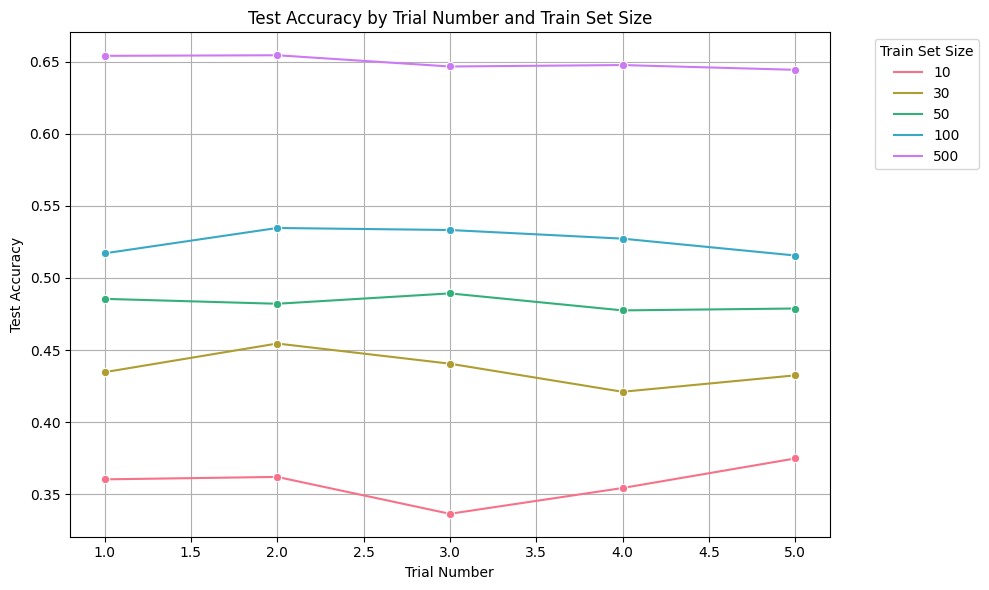

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

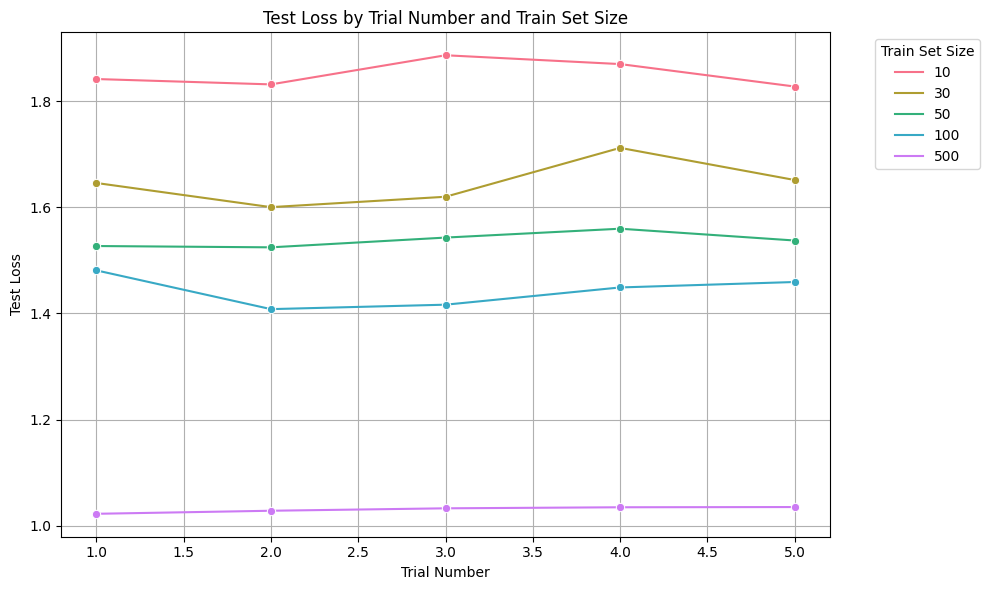

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame
columns = ['Trial Number', 'Train Set Size', 'Test Accuracy', 'Test Loss']
df = pd.DataFrame(logs_data, columns=columns)

# Display table
print(df)

# Import color palette generator for unique hues
unique_train_sizes = df['Train Set Size'].unique()
palette = sns.color_palette("husl", len(unique_train_sizes))

# Plot for Test Accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Trial Number', y='Test Accuracy', hue='Train Set Size', palette=palette, marker='o')
plt.title('Test Accuracy by Trial Number and Train Set Size')
plt.xlabel('Trial Number')
plt.ylabel('Test Accuracy')
plt.legend(title='Train Set Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Test Loss
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Trial Number', y='Test Loss', hue='Train Set Size', palette=palette, marker='o')
plt.title('Test Loss by Trial Number and Train Set Size')
plt.xlabel('Trial Number')
plt.ylabel('Test Loss')
plt.legend(title='Train Set Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()